# Problem statment:Energy demand (Electricity price) Forecasting
This is a time series forecasting problem where two distinct datasets of energy and weather data are used. The energy consumption and weather data from various cities in Spain are combined to create a multivariate time series forecasting problem. The energy dataset contains features related to the generation of energy from different sources like fossil fuels, wind, and coal. On the other hand, the weather dataset contains features related to various weather metrics such as temperature, humidity, pressure, wind speed, etc.
# Methods:
1) Machine learning: XGboost Regressor
2) Deep learning: LSTM, GRU, CNN, CNN-LSTM, LSTM-Attention
4) Hybrid methods:GRU-XGBoost, LSTM-Attention-XGBoost

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import tensorflow as tf
from tensorflow import keras

# sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

# statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# plotly
from plotly.subplots import make_subplots

# KERAS — use tf.keras 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    LSTM, GRU, Dense, Dropout, Flatten,
    Conv1D, MaxPooling1D, BatchNormalization,
    Input, Masking, Concatenate, Dot  # note: Dot (capital D), not `dot`
)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

2025-09-28 23:54:06.925433: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Energy dataset
df_energy = pd.read_csv('/Users/temp_user/ml/Time Series & Forecasting/EnergyForecasting/datasets/energy_dataset.csv')
df_energy.head()

time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   
3                 4314.0                       4131.0                  160.0   
4                 4130.0                       3840.0                  156.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   ...  generation waste  generation wind offshore  generation wind onshore  \
0  ...             196.0                       0.0                   6378.0   
1  ...             195.0                       0.0                   5890.0   
2  ...             196.0                       0.0                   5461.0   
3  ...             191.0                       0.0                   5238.0   
4  ...             189.0                       0.0                   4935.0   

   forecast solar day ahead  forecast wind offshore eday ahead  \
0                      17.0                                NaN   
1                      16.0                                NaN   
2                       8.0                                NaN   
3                       2.0                                NaN   
4                       9.0                                NaN   

   forecast wind onshore day ahead  total load forecast  total load actual  \
0                           6436.0              26118.0            25385.0   
1                           5856.0              24934.0            24382.0   
2                           5454.0              23515.0            22734.0   
3                           5151.0              22642.0            21286.0   
4                           4861.0              21785.0            20264.0   

   price day ahead  price actual  
0            50.10         65.41  
1            48.10         64.92  
2            47.33         64.48  
3            42.27         59.32  
4            38.41         56.04  

[5 rows x 29 columns]

In [3]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [4]:
df_energy.describe().T

count          mean  \
generation biomass                           35045.0    383.513540   
generation fossil brown coal/lignite         35046.0    448.059208   
generation fossil coal-derived gas           35046.0      0.000000   
generation fossil gas                        35046.0   5622.737488   
generation fossil hard coal                  35046.0   4256.065742   
generation fossil oil                        35045.0    298.319789   
generation fossil oil shale                  35046.0      0.000000   
generation fossil peat                       35046.0      0.000000   
generation geothermal                        35046.0      0.000000   
generation hydro pumped storage aggregated       0.0           NaN   
generation hydro pumped storage consumption  35045.0    475.577343   
generation hydro run-of-river and poundage   35045.0    972.116108   
generation hydro water reservoir             35046.0   2605.114735   
generation marine                            35045.0      0.000000   
generation nuclear                           35047.0   6263.907039   
generation other                             35046.0     60.228585   
generation other renewable                   35046.0     85.639702   
generation solar                             35046.0   1432.665925   
generation waste                             35045.0    269.452133   
generation wind offshore                     35046.0      0.000000   
generation wind onshore                      35046.0   5464.479769   
forecast solar day ahead                     35064.0   1439.066735   
forecast wind offshore eday ahead                0.0           NaN   
forecast wind onshore day ahead              35064.0   5471.216689   
total load forecast                          35064.0  28712.129962   
total load actual                            35028.0  28696.939905   
price day ahead                              35064.0     49.874341   
price actual                                 35064.0     57.884023   

                                                     std       min  \
generation biomass                             85.353943      0.00   
generation fossil brown coal/lignite          354.568590      0.00   
generation fossil coal-derived gas              0.000000      0.00   
generation fossil gas                        2201.830478      0.00   
generation fossil hard coal                  1961.601013      0.00   
generation fossil oil                          52.520673      0.00   
generation fossil oil shale                     0.000000      0.00   
generation fossil peat                          0.000000      0.00   
generation geothermal                           0.000000      0.00   
generation hydro pumped storage aggregated           NaN       NaN   
generation hydro pumped storage consumption   792.406614      0.00   
generation hydro run-of-river and poundage    400.777536      0.00   
generation hydro water reservoir             1835.199745      0.00   
generation marine                               0.000000      0.00   
generation nuclear                            839.667958      0.00   
generation other                               20.238381      0.00   
generation other renewable                     14.077554      0.00   
generation solar                             1680.119887      0.00   
generation waste                               50.195536      0.00   
generation wind offshore                        0.000000      0.00   
generation wind onshore                      3213.691587      0.00   
forecast solar day ahead                     1677.703355      0.00   
forecast wind offshore eday ahead                    NaN       NaN   
forecast wind onshore day ahead              3176.312853    237.00   
total load forecast                          4594.100854  18105.00   
total load actual                            4574.987950  18041.00   
price day ahead                                14.618900      2.06   
price actual                                   14.204083

In [5]:
# remove clolumns : remove features are 0 or Non also remove day ahead forcasting columns
col_names = ['generation fossil coal-derived gas', 'generation fossil oil shale','generation fossil peat',
           'generation geothermal', 'generation hydro pumped storage aggregated', 'generation marine',
           'generation wind offshore', 'forecast wind offshore eday ahead', 'forecast solar day ahead',
            'forecast wind onshore day ahead']

In [6]:
df_energy = df_energy.drop(col_names, axis = 1)

In [7]:
# Checking Nans 
print(df_energy.isnull().sum())

time                                            0
generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load forecast                             0
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64


In [8]:
# duplicates in each columns
print(df_energy.duplicated().sum())

0


In [9]:
# Timecolumn type is object so convert it to datetime
# set index of datafarme to time column
df_energy['time'] = pd.to_datetime(df_energy['time'])
df_energy = df_energy.set_index('time')
df_energy

/var/folders/bx/vc4hny055y78y0w3nz6vpmw00000gn/T/ipykernel_74018/3379659598.py:3: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_energy['time'] = pd.to_datetime(df_energy['time'])


generation biomass  \
time                                            
2015-01-01 00:00:00+01:00               447.0   
2015-01-01 01:00:00+01:00               449.0   
2015-01-01 02:00:00+01:00               448.0   
2015-01-01 03:00:00+01:00               438.0   
2015-01-01 04:00:00+01:00               428.0   
...                                       ...   
2018-12-31 19:00:00+01:00               297.0   
2018-12-31 20:00:00+01:00               296.0   
2018-12-31 21:00:00+01:00               292.0   
2018-12-31 22:00:00+01:00               293.0   
2018-12-31 23:00:00+01:00               290.0   

                           generation fossil brown coal/lignite  \
time                                                              
2015-01-01 00:00:00+01:00                                 329.0   
2015-01-01 01:00:00+01:00                                 328.0   
2015-01-01 02:00:00+01:00                                 323.0   
2015-01-01 03:00:00+01:00                                 254.0   
2015-01-01 04:00:00+01:00                                 187.0   
...                                                         ...   
2018-12-31 19:00:00+01:00                                   0.0   
2018-12-31 20:00:00+01:00                                   0.0   
2018-12-31 21:00:00+01:00                                   0.0   
2018-12-31 22:00:00+01:00                                   0.0   
2018-12-31 23:00:00+01:00                                   0.0   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2015-01-01 00:00:00+01:00                 4844.0                       4821.0   
2015-01-01 01:00:00+01:00                 5196.0                       4755.0   
2015-01-01 02:00:00+01:00                 4857.0                       4581.0   
2015-01-01 03:00:00+01:00                 4314.0                       4131.0   
2015-01-01 04:00:00+01:00                 4130.0                       3840.0   
...                                          ...                          ...   
2018-12-31 19:00:00+01:00                 7634.0                       2628.0   
2018-12-31 20:00:00+01:00                 7241.0                       2566.0   
2018-12-31 21:00:00+01:00                 7025.0                       2422.0   
2018-12-31 22:00:00+01:00                 6562.0                       2293.0   
2018-12-31 23:00:00+01:00                 6926.0                       2166.0   

                           generation fossil oil  \
time                                               
2015-01-01 00:00:00+01:00                  162.0   
2015-01-01 01:00:00+01:00                  158.0   
2015-01-01 02:00:00+01:00                  157.0   
2015-01-01 03:00:00+01:00                  160.0   
2015-01-01 04:00:00+01:00                  156.0   
...                                          ...   
2018-12-31 19:00:00+01:00                  178.0   
2018-12-31 20:00:00+01:00                  174.0   
2018-12-31 21:00:00+01:00                  168.0   
2018-12-31 22:00:00+01:00                  163.0   
2018-12-31 23:00:00+01:00                  163.0   

                           generation hydro pumped storage consumption  \
time                                                                     
2015-01-01 00:00:00+01:00                                        863.0   
2015-01-01 01:00:00+01:00                                        920.0   
2015-01-01 02:00:00+01:00                                       1164.0   
2015-01-01 03:00:00+01:00                                       1503.0   
2015-01-01 04:00:00+01:00                                       1826.0   
...                                                                ...   
2018-12-31 19:00:00+01:00                                          1.0   
2018-12-31 20:00:00+01:00                                          1.0   
2018-12-31 21:00:00+01:00                     

Text(0, 0.5, 'total load actual')

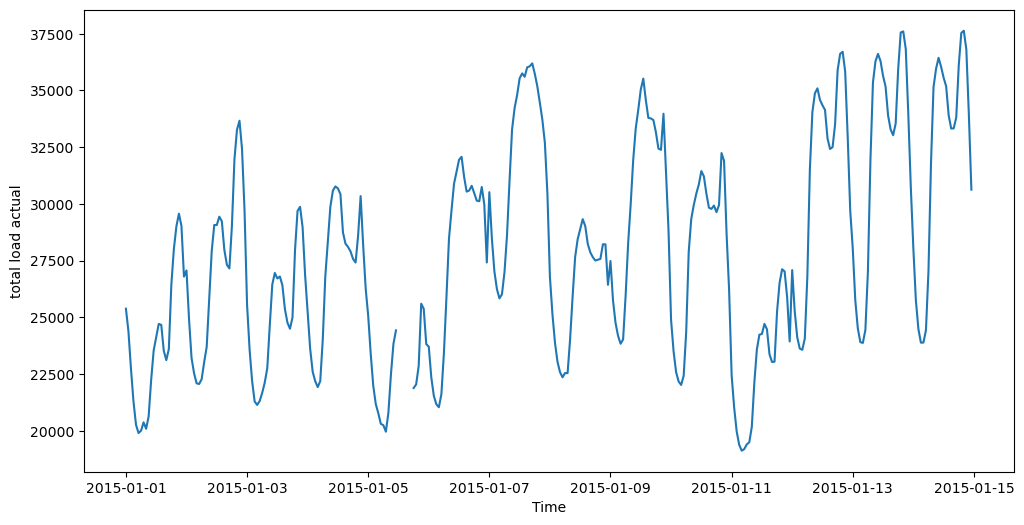

In [10]:
# plot total load actual for two weeks duration 
plt.figure(figsize=(12,6))
plt.plot(df_energy['total load actual'][:24*7*2]) #336= (24 hours × 7 days × 2 weeks)
plt.xlabel('Time')
plt.ylabel('total load actual')

# Observation:
We have few missing values (NaNs) in our time-series table.
When a series is on a regular grid (e.g., hourly), it’s usually fine to fill small gaps by interpolation (estimate the missing point between two known points—“linear” means a straight line between neighbors).

If there are big gaps or lots of NaNs, drop those parts (or handle them separately), because filling large holes can add noise/bias.

So the plan is to linearly interpolate the NaNs.
# How to select method:
1) Small gaps (≤6–12 hrs) on hourly data → time (or linear) is safe and fast.
2) we need smoothness without overshoot (preserve local shapes/monotonicity) → pchip.
3) Spiky/step-like signals (e.g., statuses) → pad/ffill or bfill (no new values invented).

In [11]:
df_energy.interpolate(method='linear', limit_direction='forward', inplace = True)

In [12]:
# there is no any Nan in energy detaset
print(df_energy.isnull().sum())

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load forecast                            0
total load actual                              0
price day ahead                                0
price actual                                   0
dtype: int64


# Feature Correlation

In [13]:
# pearson corrolation used for finding linear corrolation by having continues data and few out layers
def feat_corr(input_df):
    corr = input_df.corr(numeric_only=True)
    plt.figure(figsize=(15,12))
    #plot heat map
    g=sns.heatmap(corr,annot=True,cmap="RdYlGn", vmin=-1, vmax=1)
    plt.title('Feature Correlation')
    
    return plt.show()

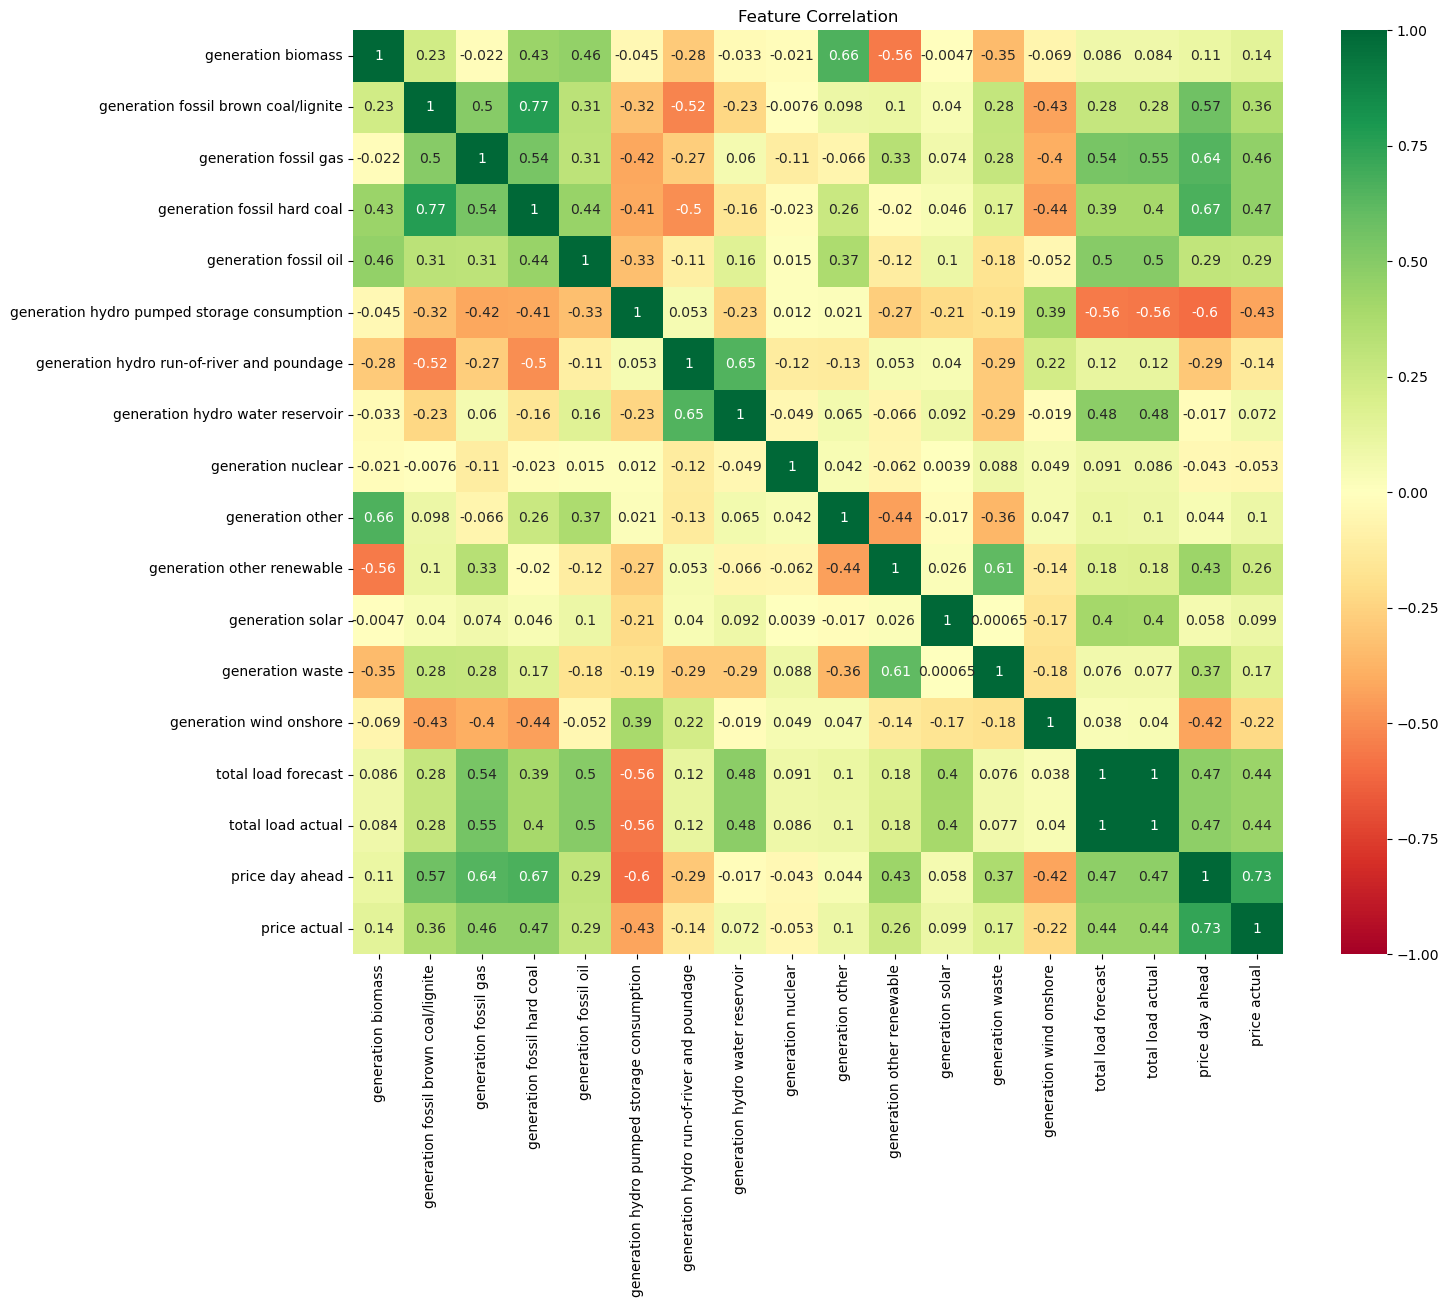

In [14]:
feat_corr(df_energy)

# Observation
Based on the feaure correlation, There is a strong correlation between "generation fossil hard coal" and "generation fossil brown coal/lignite". So with a common sense we can combine these two feature as a "generation fossil total" and remove them.
Note : There is a very high correlation between Total load forecasting and total load actual. For now, I will keep this for visulization part of this project but before feeding the data into model I will drop this column.

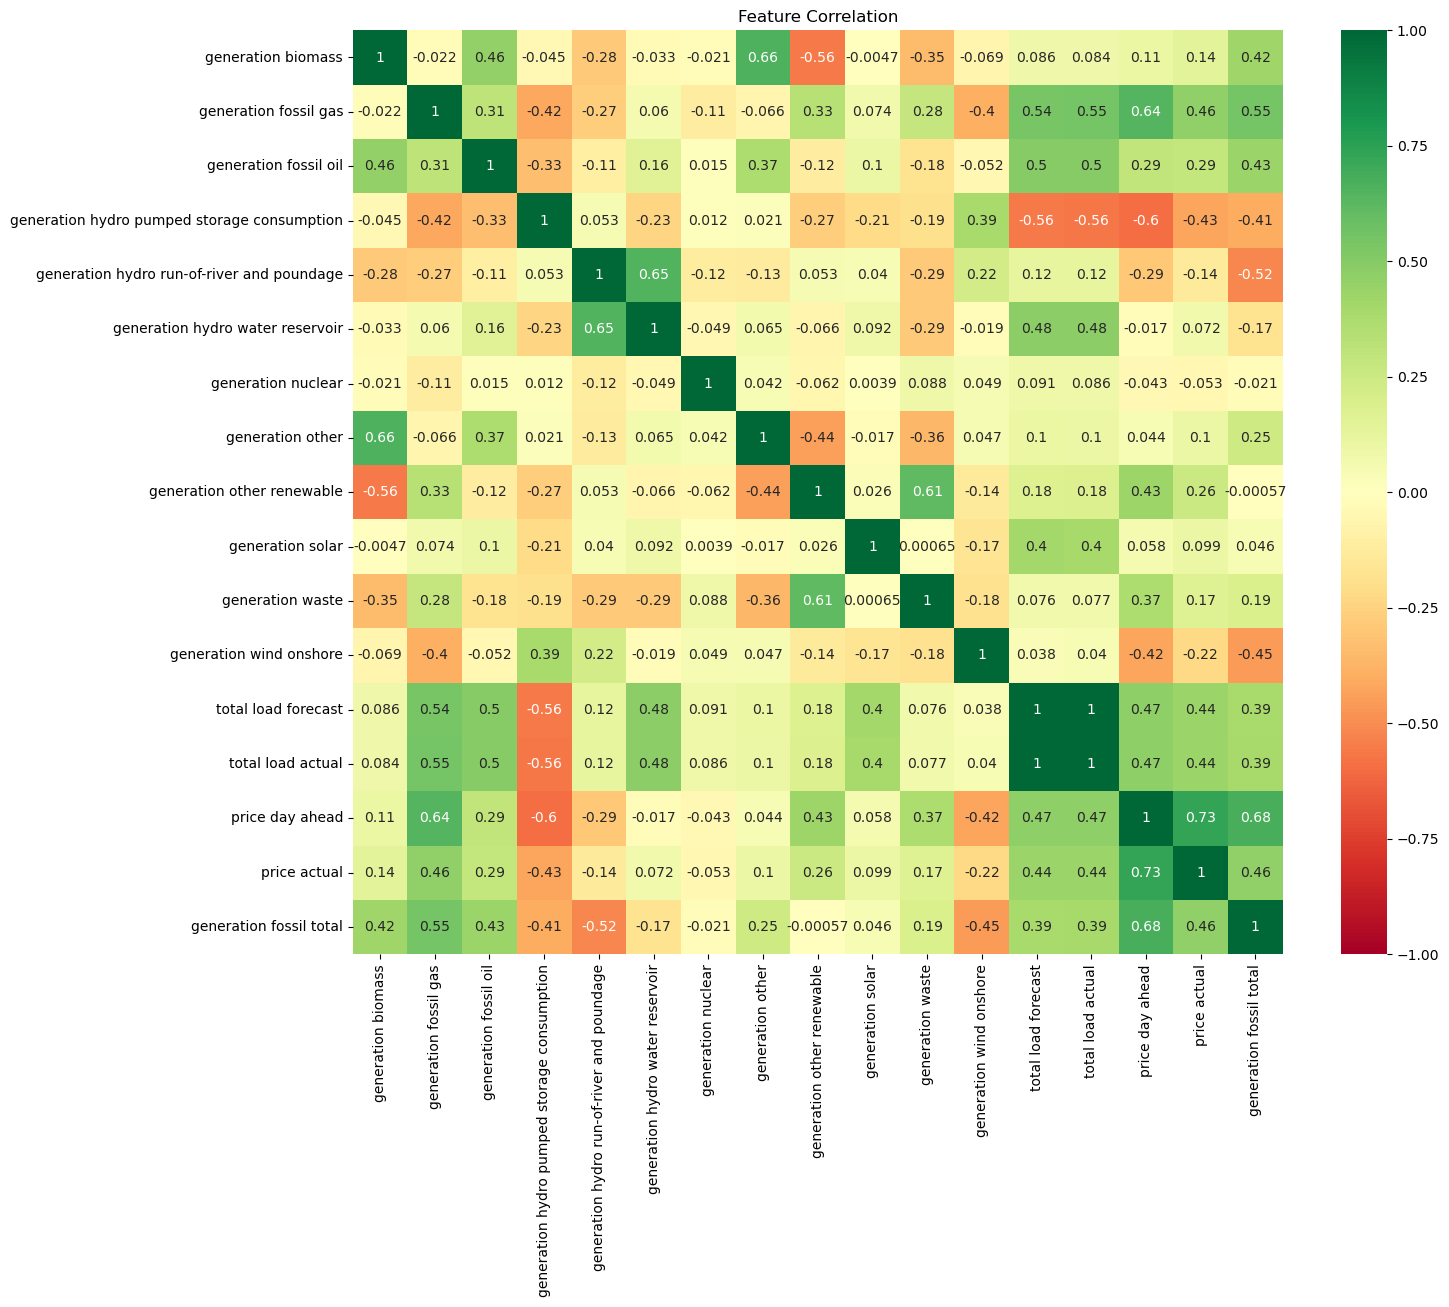

In [15]:
df_energy["generation fossil total"] = df_energy['generation fossil hard coal'] + df_energy['generation fossil brown coal/lignite']
df_energy.drop(['generation fossil hard coal', 'generation fossil brown coal/lignite'], axis = 1, inplace = True)
feat_corr(df_energy)

# Weather dataset

In [16]:
# Loading weather data
df_weather = pd.read_csv('/Users/temp_user/ml/Time Series & Forecasting/EnergyForecasting/datasets/weather_features.csv')

In [17]:
df_weather

dt_iso city_name     temp  temp_min  temp_max  \
0       2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475   
1       2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475   
2       2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686   
3       2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686   
4       2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686   
...                           ...       ...      ...       ...       ...   
178391  2018-12-31 19:00:00+01:00   Seville  287.760   287.150   288.150   
178392  2018-12-31 20:00:00+01:00   Seville  285.760   285.150   286.150   
178393  2018-12-31 21:00:00+01:00   Seville  285.150   285.150   285.150   
178394  2018-12-31 22:00:00+01:00   Seville  284.150   284.150   284.150   
178395  2018-12-31 23:00:00+01:00   Seville  283.970   282.150   285.150   

        pressure  humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  \
0           1001        77           1        62      0.0      0.0      0.0   
1           1001        77           1        62      0.0      0.0      0.0   
2           1002        78           0        23      0.0      0.0      0.0   
3           1002        78           0        23      0.0      0.0      0.0   
4           1002        78           0        23      0.0      0.0      0.0   
...          ...       ...         ...       ...      ...      ...      ...   
178391      1028        54           3        30      0.0      0.0      0.0   
178392      1029        62           3        30      0.0      0.0      0.0   
178393      1028        58           4        50      0.0      0.0      0.0   
178394      1029        57           4        60      0.0      0.0      0.0   
178395      1029        70           3        50      0.0      0.0      0.0   

        clouds_all  weather_id weather_main weather_description weather_icon  
0                0         800        clear        sky is clear          01n  
1                0         800        clear        sky is clear          01n  
2                0         800        clear        sky is clear          01n  
3                0         800        clear        sky is clear          01n  
4                0         800        clear        sky is clear          01n  
...            ...         ...          ...                 ...          ...  
178391           0         800        clear        sky is clear          01n  
178392           0         800        clear        sky is clear          01n  
178393           0         800        clear        sky is clear          01n  
178394           0         800        clear        sky is clear          01n  
178395           0         800        clear        sky is clear          01n  

[178396 rows x 17 columns]

In [18]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [19]:
df_weather["weather_main"].value_counts()

weather_main
clear           82685
clouds          68055
rain            17391
mist             3908
fog              2506
drizzle          1724
thunderstorm     1041
haze              435
dust              347
snow              270
smoke              33
squall              1
Name: count, dtype: int64

In [20]:
# we have some categorical columns that we want to see is there any corrolation between them
df_temp = df_weather.copy(deep = True)
labels = ['weather_id', 'weather_main','weather_description','weather_icon']
for col in labels:
    df_temp[col] = LabelEncoder().fit_transform(df_weather[col])

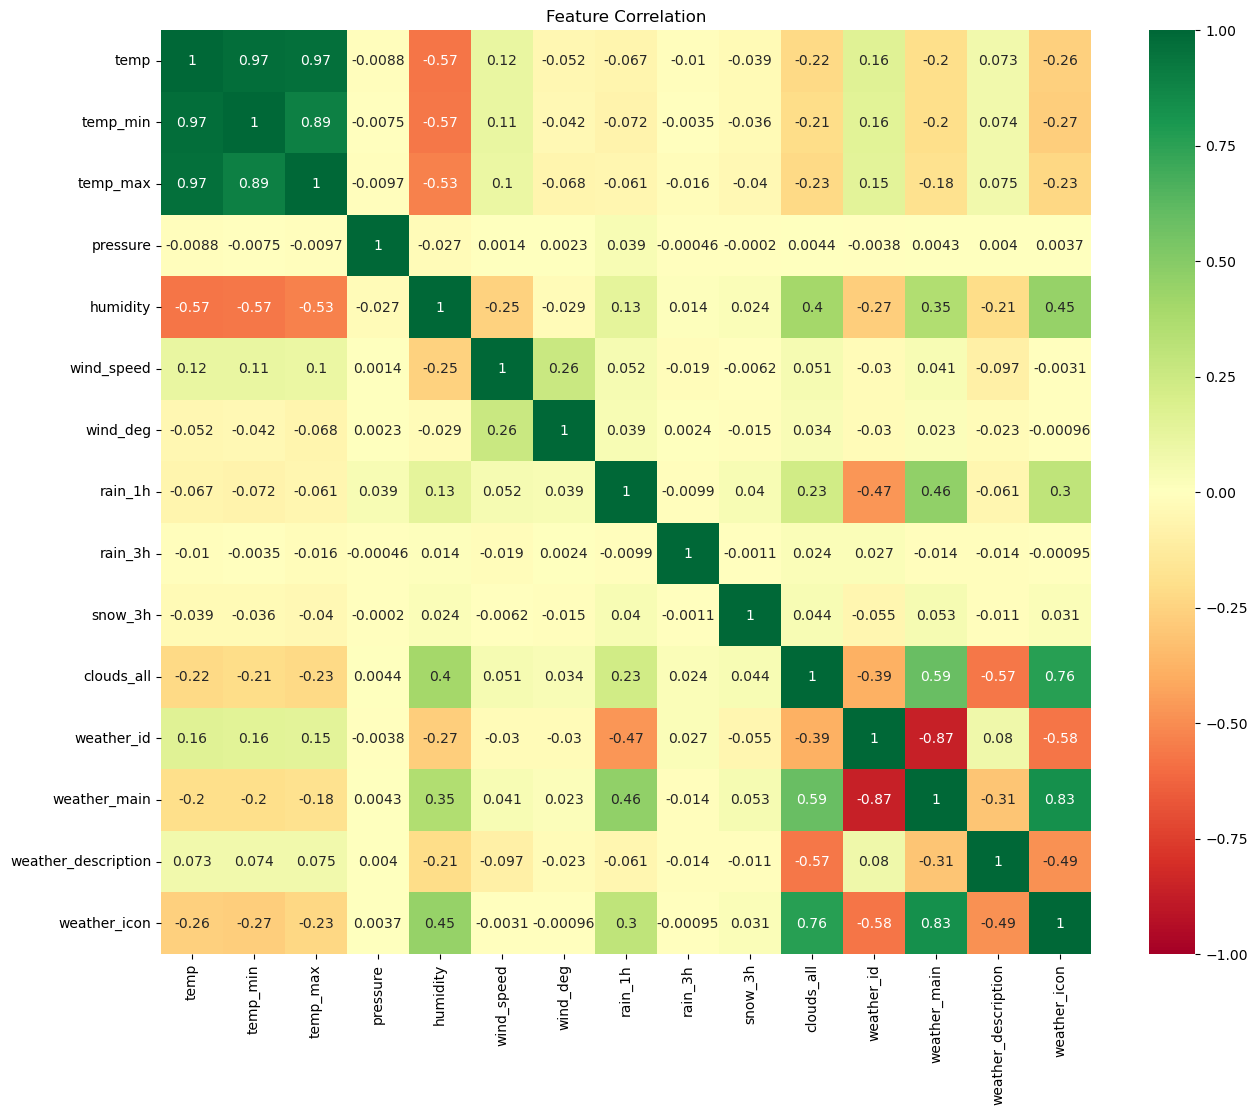

In [21]:
feat_corr(df_temp)

# Observation

Based on the feaure correlation, There is a strong correlation between "generation fossil hard coal" and "generation fossil brown coal/lignite". So with a common sense we can combine these two feature as a "generation fossil total" and remove them.
Note : There is a very high correlation between Total load forecasting and total load actual. For now, I will keep this for visulization part of this project but before feeding the data into model I will drop this column.

Having strong correlation between features might cuase multicolinearity. So, we can drop 'weather_icon', 'weather_main', 'weather_description', and 'weather_id' and just keep 'clouds_all'. There is also a very strong correlation between 'temp', 'temp_min' and 'temp_max'. So we drop temp_max and temp_min and just keep 'temp'.

In [22]:
df_weather['weather_id'].unique()
#df_weather["weather_main"].value_counts()
#df_weather["weather_description"].value_counts()
#df_weather["weather_icon"].value_counts()

array([800, 801, 802, 803, 804, 500, 501, 502, 701, 522, 521, 503, 202,
       200, 201, 211, 520, 300, 741, 301, 711, 302, 721, 310, 600, 616,
       615, 601, 210, 602, 611, 311, 612, 620, 531, 731, 761, 771])

In [23]:
col_drop_name = ['weather_id', 'weather_main','weather_description','weather_icon']
#col_drop_name = ['weather_id', 'weather_main','weather_description','weather_icon', 'temp_min', 'temp_max']
df_weather.drop(col_drop_name, axis = 1 , inplace = True)

In [24]:
print(df_weather.isnull().sum())

dt_iso        0
city_name     0
temp          0
temp_min      0
temp_max      0
pressure      0
humidity      0
wind_speed    0
wind_deg      0
rain_1h       0
rain_3h       0
snow_3h       0
clouds_all    0
dtype: int64


In [25]:
print(f'Num of duplicated: {df_weather.duplicated().sum}')

Num of duplicated: <bound method Series.sum of 0         False
1         False
2         False
3         False
4         False
          ...  
178391    False
178392    False
178393    False
178394    False
178395    False
Length: 178396, dtype: bool>


In [26]:
# change name of dt_iso to time and convert to datetime
df_weather['time'] = pd.to_datetime(df_weather['dt_iso'])
df_weather.drop(["dt_iso"] , axis = 1, inplace = True)
df_weather = df_weather.set_index('time')

/var/folders/bx/vc4hny055y78y0w3nz6vpmw00000gn/T/ipykernel_74018/2870766313.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_weather['time'] = pd.to_datetime(df_weather['dt_iso'])


In [27]:
df_weather

city_name     temp  temp_min  temp_max  pressure  \
time                                                                         
2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
...                             ...      ...       ...       ...       ...   
2018-12-31 19:00:00+01:00   Seville  287.760   287.150   288.150      1028   
2018-12-31 20:00:00+01:00   Seville  285.760   285.150   286.150      1029   
2018-12-31 21:00:00+01:00   Seville  285.150   285.150   285.150      1028   
2018-12-31 22:00:00+01:00   Seville  284.150   284.150   284.150      1029   
2018-12-31 23:00:00+01:00   Seville  283.970   282.150   285.150      1029   

                           humidity  wind_speed  wind_deg  rain_1h  rain_3h  \
time                                                                          
2015-01-01 00:00:00+01:00        77           1        62      0.0      0.0   
2015-01-01 01:00:00+01:00        77           1        62      0.0      0.0   
2015-01-01 02:00:00+01:00        78           0        23      0.0      0.0   
2015-01-01 03:00:00+01:00        78           0        23      0.0      0.0   
2015-01-01 04:00:00+01:00        78           0        23      0.0      0.0   
...                             ...         ...       ...      ...      ...   
2018-12-31 19:00:00+01:00        54           3        30      0.0      0.0   
2018-12-31 20:00:00+01:00        62           3        30      0.0      0.0   
2018-12-31 21:00:00+01:00        58           4        50      0.0      0.0   
2018-12-31 22:00:00+01:00        57           4        60      0.0      0.0   
2018-12-31 23:00:00+01:00        70           3        50      0.0      0.0   

                           snow_3h  clouds_all  
time                                            
2015-01-01 00:00:00+01:00      0.0           0  
2015-01-01 01:00:00+01:00      0.0           0  
2015-01-01 02:00:00+01:00      0.0           0  
2015-01-01 03:00:00+01:00      0.0           0  
2015-01-01 04:00:00+01:00      0.0           0  
...                            ...         ...  
2018-12-31 19:00:00+01:00      0.0           0  
2018-12-31 20:00:00+01:00      0.0           0  
2018-12-31 21:00:00+01:00      0.0           0  
2018-12-31 22:00:00+01:00      0.0           0  
2018-12-31 23:00:00+01:00      0.0           0  

[178396 rows x 12 columns]

# Finding outliers 
Based on stats below, we can see that there are some outliers in pressure, wind_speed and maybe rain_1h and rain_3h. So we can see outliers in the plots. we will remove pressure and wind_speed outlier and also drop rain_3h. Becuase rain_3h is supposed to be the amount of percipitation in the last 3 hr which should be higher than rain_1h, but the plot does not confirm this. So we drop rain_3h.

In [28]:
df_weather.describe().round(2)

temp   temp_min   temp_max    pressure   humidity  wind_speed  \
count  178396.00  178396.00  178396.00   178396.00  178396.00   178396.00   
mean      289.62     288.33     291.09     1069.26      68.42        2.47   
std         8.03       7.96       8.61     5969.63      21.90        2.10   
min       262.24     262.24     262.24        0.00       0.00        0.00   
25%       283.67     282.48     284.65     1013.00      53.00        1.00   
50%       289.15     288.15     290.15     1018.00      72.00        2.00   
75%       295.15     293.73     297.15     1022.00      87.00        4.00   
max       315.60     315.15     321.15  1008371.00     100.00      133.00   

        wind_deg    rain_1h    rain_3h    snow_3h  clouds_all  
count  178396.00  178396.00  178396.00  178396.00   178396.00  
mean      166.59       0.08       0.00       0.00       25.07  
std       116.61       0.40       0.01       0.22       30.77  
min         0.00       0.00       0.00       0.00        0.00  
25%        55.00       0.00       0.00       0.00        0.00  
50%       177.00       0.00       0.00       0.00       20.00  
75%       270.00       0.00       0.00       0.00       40.00  
max       360.00      12.00       2.32      21.50      100.00

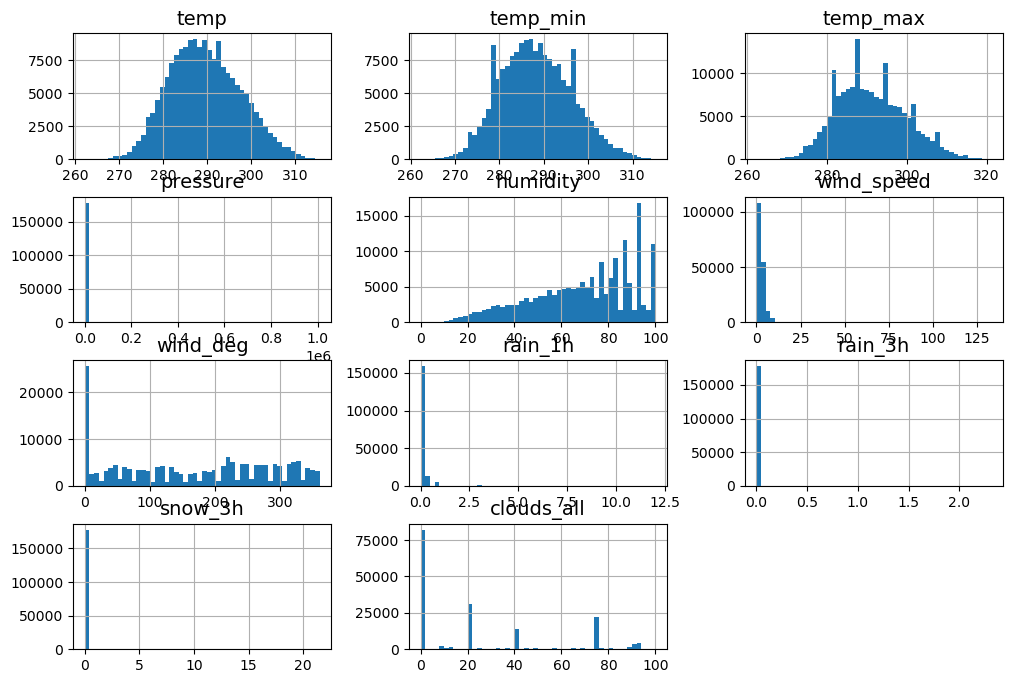

In [29]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
df_weather.hist(bins=50, figsize=(12, 8))
plt.show()

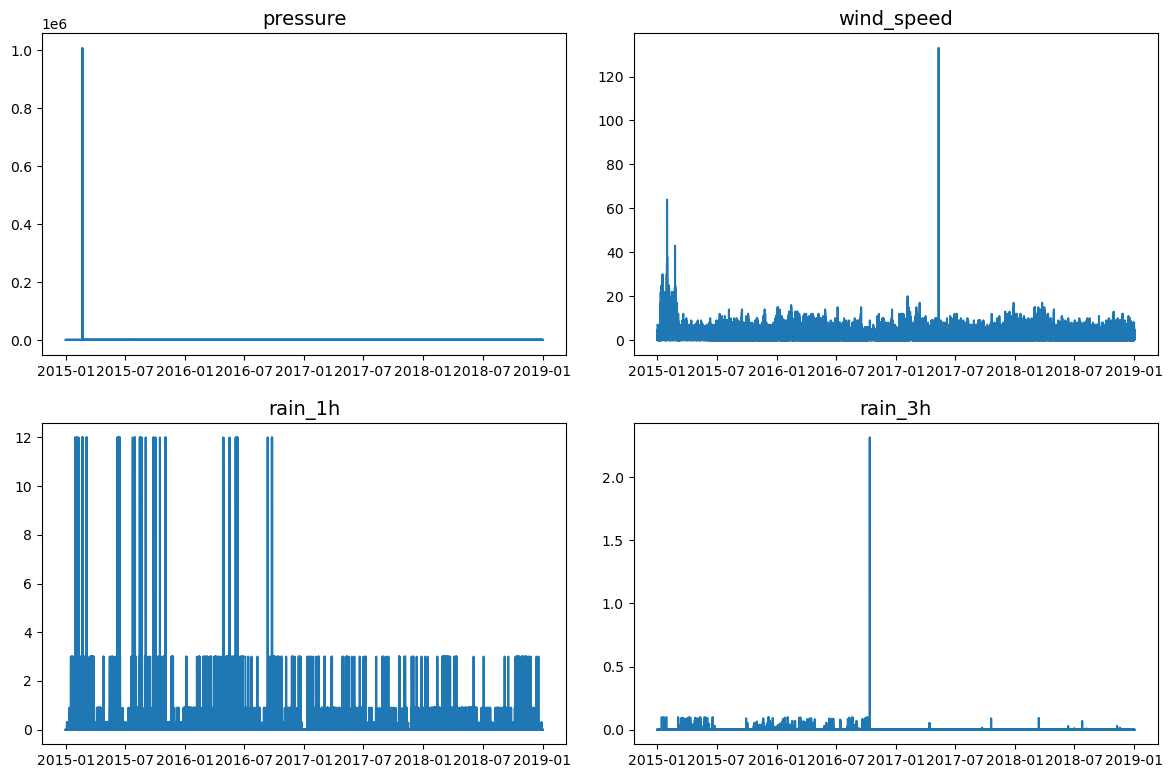

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

# select the columns to plot
columns_to_plot = ['pressure', 'wind_speed', 'rain_1h', 'rain_3h']

# loop through the subplots and plot each column
for i, ax in enumerate(axes.flat):
    if i < len(columns_to_plot):
        ax.plot(df_weather.index, df_weather[columns_to_plot[i]])
        ax.set_title(columns_to_plot[i])
    else:
        ax.set_visible(False)

plt.tight_layout()  # adjust the spacing between subplots
plt.show()  # display the plot                    

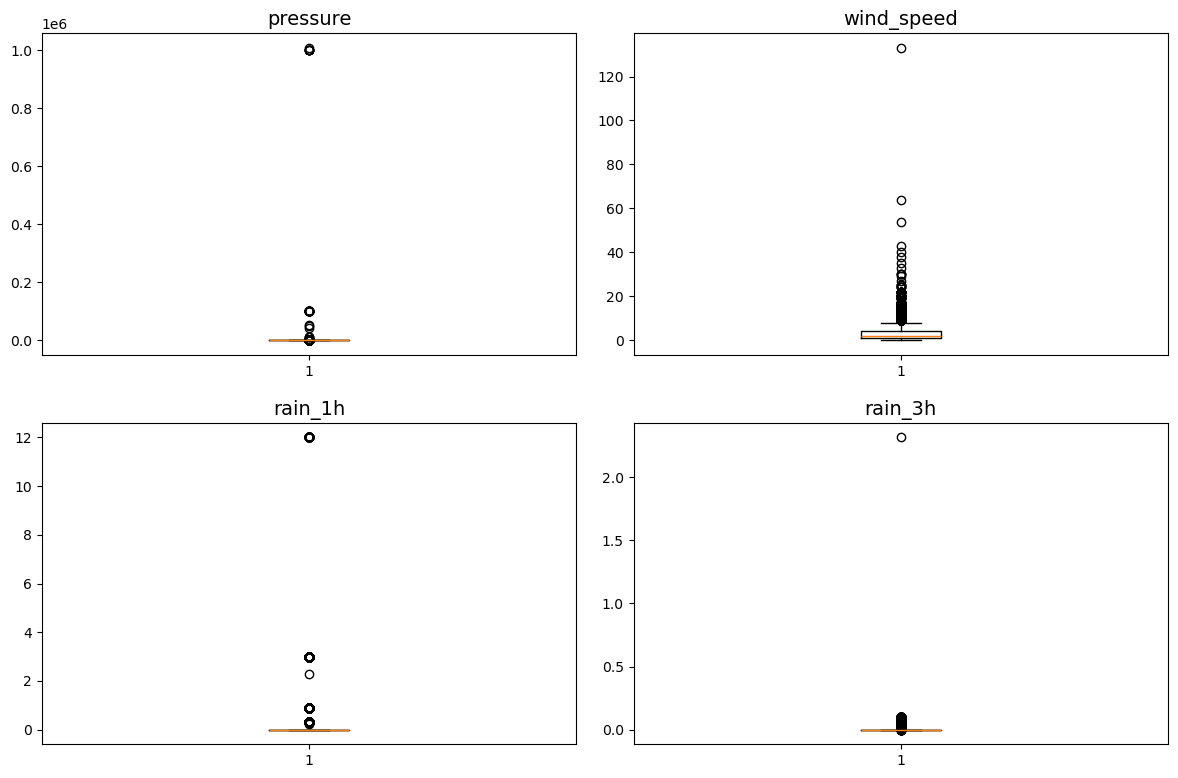

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

# select the columns to plot
columns_to_plot = ['pressure', 'wind_speed', 'rain_1h', 'rain_3h']

# loop through the subplots and plot each column
for i, ax in enumerate(axes.flat):
    if i < len(columns_to_plot):
        ax.boxplot(x = df_weather[columns_to_plot[i]])
        ax.set_title(columns_to_plot[i])
    else:
        ax.set_visible(False)

plt.tight_layout()  # adjust the spacing between subplots
plt.show()  # display the plot

Maximum pressure on earth is recorded as 1080hPa : https://wmo.asu.edu/content/world-highest-sea-level-air-pressure-below-700m
Minimum pressure on earth is recorded as 870hPa : https://wmo.asu.edu/content/world-lowest-sea-level-air-pressure-excluding-tornadoes
Maximum wind speed on earth is recorded as 113 m/s : https://www.wunderground.com/cat6/the-highest-anemometer-measured-wind-speeds-on-earth

So we set the max threshold as these numbers and replace the outliers with Nan values and then use interpolation to fill the gap.

In [32]:
df_weather.loc[df_weather['pressure']  > 1080,  'pressure'] = np.nan
df_weather.loc[df_weather['pressure']   < 870,  'pressure'] = np.nan
df_weather.loc[df_weather['wind_speed'] > 113, 'wind_speed'] = np.nan

df_weather.interpolate(method ='linear', limit_direction ='forward', inplace = True)

/var/folders/bx/vc4hny055y78y0w3nz6vpmw00000gn/T/ipykernel_74018/42852904.py:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_weather.interpolate(method ='linear', limit_direction ='forward', inplace = True)


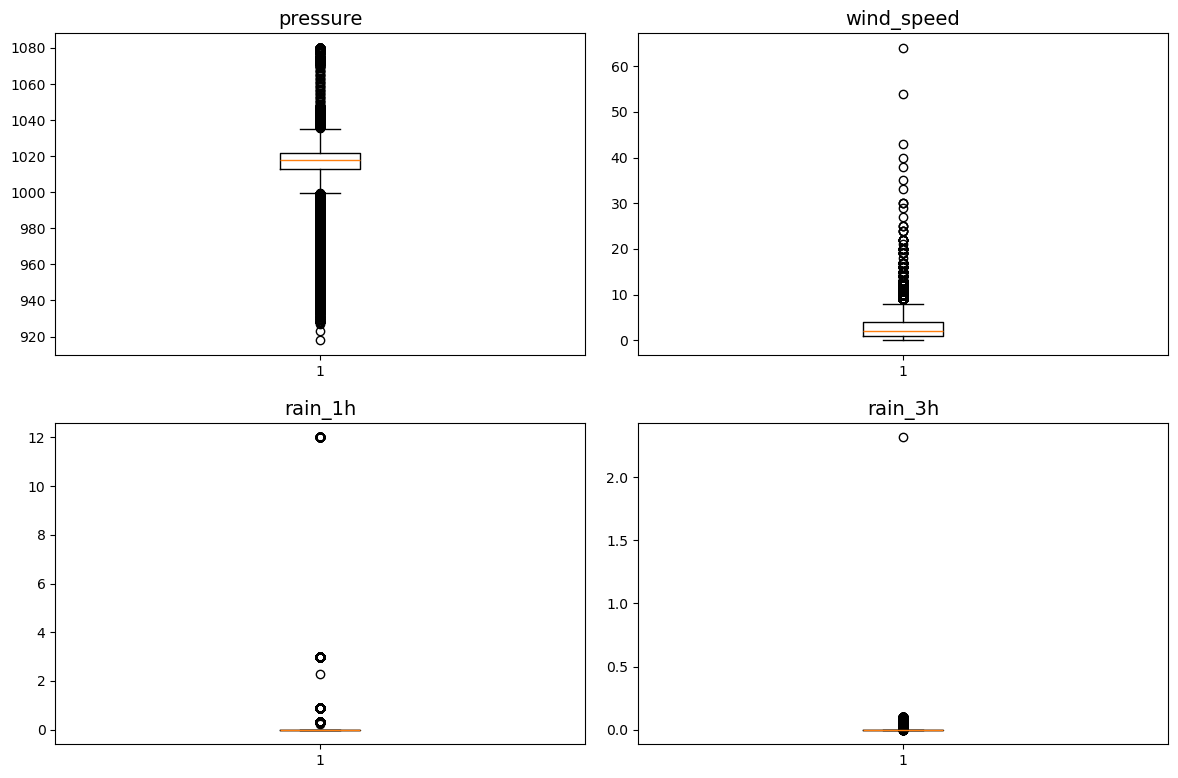

In [33]:
# check outliers remove
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

# select the columns to plot
columns_to_plot = ['pressure', 'wind_speed', 'rain_1h', 'rain_3h']

# loop through the subplots and plot each column
for i, ax in enumerate(axes.flat):
    if i < len(columns_to_plot):
        ax.boxplot(x = df_weather[columns_to_plot[i]])
        ax.set_title(columns_to_plot[i])
    else:
        ax.set_visible(False)

plt.tight_layout()  # adjust the spacing between subplots
plt.show()  # display the plot

In [34]:
df_weather.describe().round(2)

temp   temp_min   temp_max   pressure   humidity  wind_speed  \
count  178396.00  178396.00  178396.00  178396.00  178396.00   178396.00   
mean      289.62     288.33     291.09    1016.19      68.42        2.47   
std         8.03       7.96       8.61      12.37      21.90        2.07   
min       262.24     262.24     262.24     918.00       0.00        0.00   
25%       283.67     282.48     284.65    1013.00      53.00        1.00   
50%       289.15     288.15     290.15    1018.00      72.00        2.00   
75%       295.15     293.73     297.15    1022.00      87.00        4.00   
max       315.60     315.15     321.15    1080.00     100.00       64.00   

        wind_deg    rain_1h    rain_3h    snow_3h  clouds_all  
count  178396.00  178396.00  178396.00  178396.00   178396.00  
mean      166.59       0.08       0.00       0.00       25.07  
std       116.61       0.40       0.01       0.22       30.77  
min         0.00       0.00       0.00       0.00        0.00  
25%        55.00       0.00       0.00       0.00        0.00  
50%       177.00       0.00       0.00       0.00       20.00  
75%       270.00       0.00       0.00       0.00       40.00  
max       360.00      12.00       2.32      21.50      100.00

In [35]:
# drope rain_h3
df_weather.drop(['rain_3h'],axis=1,inplace=True)
df_weather.head()

city_name     temp  temp_min  temp_max  pressure  \
time                                                                         
2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475    1001.0   
2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475    1001.0   
2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686    1002.0   
2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686    1002.0   
2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686    1002.0   

                           humidity  wind_speed  wind_deg  rain_1h  snow_3h  \
time                                                                          
2015-01-01 00:00:00+01:00        77         1.0        62      0.0      0.0   
2015-01-01 01:00:00+01:00        77         1.0        62      0.0      0.0   
2015-01-01 02:00:00+01:00        78         0.0        23      0.0      0.0   
2015-01-01 03:00:00+01:00        78         0.0        23      0.0      0.0   
2015-01-01 04:00:00+01:00        78         0.0        23      0.0      0.0   

                           clouds_all  
time                                   
2015-01-01 00:00:00+01:00           0  
2015-01-01 01:00:00+01:00           0  
2015-01-01 02:00:00+01:00           0  
2015-01-01 03:00:00+01:00           0  
2015-01-01 04:00:00+01:00           0

In [36]:
# check how many cities there are
city_list=df_weather['city_name'].unique()
city_list

array(['Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'],
      dtype=object)

In [37]:
# group based on city name
grouped_weather = df_weather.groupby('city_name')

In [38]:
# check number of samples in each city
for city in city_list:
    print(f'number of samples in df_weather in {city} is {grouped_weather.get_group(city).shape[0]}')

number of samples in df_weather in Valencia is 35145
number of samples in df_weather in Madrid is 36267
number of samples in df_weather in Bilbao is 35951
number of samples in df_weather in  Barcelona is 35476
number of samples in df_weather in Seville is 35557


In [39]:
# number of samples for each city is not consistent, there are duplicates
df_weather_cleaned = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'], keep='first').set_index('time')

In [40]:
df_weather_cleaned

city_name     temp  temp_min  temp_max  pressure  \
time                                                                         
2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475    1001.0   
2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475    1001.0   
2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686    1002.0   
2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686    1002.0   
2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686    1002.0   
...                             ...      ...       ...       ...       ...   
2018-12-31 19:00:00+01:00   Seville  287.760   287.150   288.150    1028.0   
2018-12-31 20:00:00+01:00   Seville  285.760   285.150   286.150    1029.0   
2018-12-31 21:00:00+01:00   Seville  285.150   285.150   285.150    1028.0   
2018-12-31 22:00:00+01:00   Seville  284.150   284.150   284.150    1029.0   
2018-12-31 23:00:00+01:00   Seville  283.970   282.150   285.150    1029.0   

                           humidity  wind_speed  wind_deg  rain_1h  snow_3h  \
time                                                                          
2015-01-01 00:00:00+01:00        77         1.0        62      0.0      0.0   
2015-01-01 01:00:00+01:00        77         1.0        62      0.0      0.0   
2015-01-01 02:00:00+01:00        78         0.0        23      0.0      0.0   
2015-01-01 03:00:00+01:00        78         0.0        23      0.0      0.0   
2015-01-01 04:00:00+01:00        78         0.0        23      0.0      0.0   
...                             ...         ...       ...      ...      ...   
2018-12-31 19:00:00+01:00        54         3.0        30      0.0      0.0   
2018-12-31 20:00:00+01:00        62         3.0        30      0.0      0.0   
2018-12-31 21:00:00+01:00        58         4.0        50      0.0      0.0   
2018-12-31 22:00:00+01:00        57         4.0        60      0.0      0.0   
2018-12-31 23:00:00+01:00        70         3.0        50      0.0      0.0   

                           clouds_all  
time                                   
2015-01-01 00:00:00+01:00           0  
2015-01-01 01:00:00+01:00           0  
2015-01-01 02:00:00+01:00           0  
2015-01-01 03:00:00+01:00           0  
2015-01-01 04:00:00+01:00           0  
...                               ...  
2018-12-31 19:00:00+01:00           0  
2018-12-31 20:00:00+01:00           0  
2018-12-31 21:00:00+01:00           0  
2018-12-31 22:00:00+01:00           0  
2018-12-31 23:00:00+01:00           0  

[175320 rows x 11 columns]

In [41]:
# check number of sample in each city
print(f'Number of samples in df_energy is {df_energy.shape[0]}')

city_list = df_weather['city_name'].unique()
grouped_weather = df_weather_cleaned.groupby('city_name')

for city in city_list:
    print(f'Number of samples in df_weather in {city} is {grouped_weather.get_group(city).shape[0]}')

Number of samples in df_energy is 35064
Number of samples in df_weather in Valencia is 35064
Number of samples in df_weather in Madrid is 35064
Number of samples in df_weather in Bilbao is 35064
Number of samples in df_weather in  Barcelona is 35064
Number of samples in df_weather in Seville is 35064


# 
Now number of samples in each city is the same. So we can concatenate wether dataframe with energy dataframe.

In [42]:
# creating df_weather for each city
df_weather_all_cities = [grouped_weather.get_group(x) for x in grouped_weather.groups]

In [43]:
df_weather_all_cities

[                            city_name     temp  temp_min  temp_max  pressure  \
 time                                                                           
 2015-01-01 00:00:00+01:00   Barcelona  281.625   281.625   281.625    1035.0   
 2015-01-01 01:00:00+01:00   Barcelona  281.625   281.625   281.625    1035.0   
 2015-01-01 02:00:00+01:00   Barcelona  281.286   281.286   281.286    1036.0   
 2015-01-01 03:00:00+01:00   Barcelona  281.286   281.286   281.286    1036.0   
 2015-01-01 04:00:00+01:00   Barcelona  281.286   281.286   281.286    1036.0   
 ...                               ...      ...       ...       ...       ...   
 2018-12-31 19:00:00+01:00   Barcelona  284.130   282.150   286.150    1027.0   
 2018-12-31 20:00:00+01:00   Barcelona  282.640   281.150   284.150    1027.0   
 2018-12-31 21:00:00+01:00   Barcelona  282.140   280.150   284.150    1028.0   
 2018-12-31 22:00:00+01:00   Barcelona  281.130   278.150   284.150    1028.0   
 2018-12-31 23:00:00+01:00  

In [44]:
df_energy.shape

(35064, 17)

In [45]:
df_weather_energy = df_energy
for df_city in df_weather_all_cities:
    city_name=df_city.iloc[0]['city_name'].replace(' ','') # remove space between name of city "san fransisco" to sanfransisico"
    df_temp_city = df_city.add_suffix(f'_{city_name}') # add city name to each column of df_city 
    df_weather_energy = pd.concat([df_weather_energy, df_temp_city], axis=1) # concatenate df_city to df_energy as new df called df-weather_energy
    df_weather_energy = df_weather_energy.drop(f'city_name_{city_name}' , axis=1) # Drop the now-redundant city_name column
    

In [46]:
df_weather_energy.shape

(35064, 67)

In [47]:
print(df_weather_energy.isnull().sum())

generation biomass                             0
generation fossil gas                          0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
                                              ..
wind_speed_Valencia                            0
wind_deg_Valencia                              0
rain_1h_Valencia                               0
snow_3h_Valencia                               0
clouds_all_Valencia                            0
Length: 67, dtype: int64


In [48]:
print(df_weather_energy.duplicated().sum())

0


# Feature engineering
we add hour, weekday and month features to dataframe. These information can be helpful. For example in shoulder seasons the heating and cooling load of all residential and commercial buildings will be low compared to summer/winter. or at the weekend, since the office buildings are closed, the energy consumption will be lower.Regading the time, defintily energy consumption at 3 am is way lower than the energy consumption at 10 am. So these features can be very helpful in building a good model.

In [49]:
df_weather_energy['hour']    = df_weather_energy.index.map(lambda x: x.hour) 
df_weather_energy['weekday'] = df_weather_energy.index.map(lambda x : x.weekday()) 
df_weather_energy['month']   = df_weather_energy.index.map(lambda x: x.month)
df_weather_energy['year']    = df_weather_energy.index.map(lambda x:x.year)

In [50]:
df_weather_energy.columns

Index(['generation biomass', 'generation fossil gas', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual',
       'generation fossil total', 'temp_Barcelona', 'temp_min_Barcelona',
       'temp_max_Barcelona', 'pressure_Barcelona', 'humidity_Barcelona',
       'wind_speed_Barcelona', 'wind_deg_Barcelona', 'rain_1h_Barcelona',
       'snow_3h_Barcelona', 'clouds_all_Barcelona', 'temp_Bilbao',
       'temp_min_Bilbao', 'temp_max_Bilbao', 'pressure_Bilbao',
       'humidity_Bilbao', 'wind_speed_Bilbao', 'wind_deg_Bilbao',
       'rain_1h_Bilbao', 'snow_3h_Bilbao', 'clouds_all_Bilbao', 'temp_Madrid',
       'temp_min_Madrid', 'temp_max

In [51]:
start = df_weather_energy.index.min()
end   = df_weather_energy.index.max()
print("Start:", start, " End:", end)

Start: 2015-01-01 00:00:00+01:00  End: 2018-12-31 23:00:00+01:00


In [52]:
df_weather_energy['price actual'].describe()

count    35064.000000
mean        57.884023
std         14.204083
min          9.330000
25%         49.347500
50%         58.020000
75%         68.010000
max        116.800000
Name: price actual, dtype: float64

# 
14.2 spread around the mean
25% of prices are ≤ 49.35.

# Visualization 
The raw price line is often jagged/noisy.The daily and weekly rolling averages smooth out noise so you can see trends and seasonality (daily cycles, weekly patterns).

In [53]:
fig = make_subplots()

fig.add_trace(go.Scatter(
    x=df_weather_energy.index,
    y=df_weather_energy["price actual"],
    mode="lines",
    name="price actual"
))

fig.add_trace(go.Scatter(
    x=df_weather_energy.index,
    y=df_weather_energy.rolling(24).mean()["price actual"],
    mode="lines",
    name="rolling window = daily ave"
))

fig.add_trace(go.Scatter(
    x=df_weather_energy.index,
    y=df_weather_energy.rolling(24*7).mean()["price actual"],
    mode="lines",
    name="rolling window = weekly ave"
))
fig.show()

Text(0.5, 1.0, 'Daily actual price (0 is Monday)')

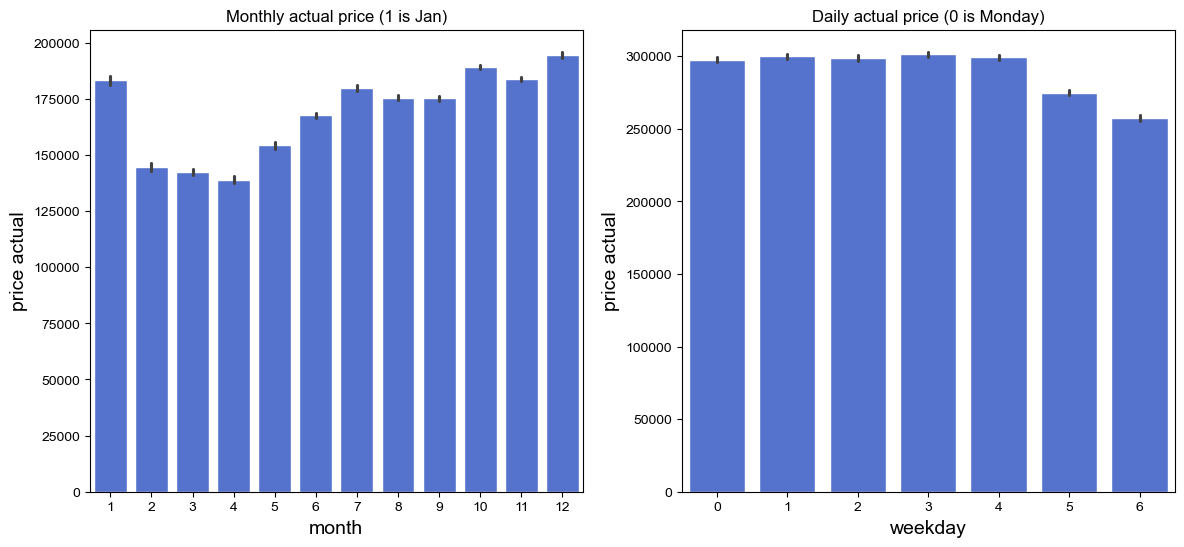

In [54]:
# total price actual per month across the whole dataset
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.set(style="darkgrid")

sns.barplot(
    x="month", 
    y="price actual", 
    data=df_weather_energy, 
    estimator=sum, 
    color='royalblue',
    ax=axes[0]);
axes[0].set_title('Monthly actual price (1 is Jan)')
# total price actual per day across the whole dataset
sns.barplot(
    x="weekday", 
    y="price actual", 
    data=df_weather_energy, 
    estimator=sum, 
    color='royalblue',
    ax=axes[1]);
axes[1].set_title('Daily actual price (0 is Monday)')

# Observation
Based on the month bar plot, the actual price in Jan and Dec is high and on weekly daily basis, we witness the lowest price at weekends.

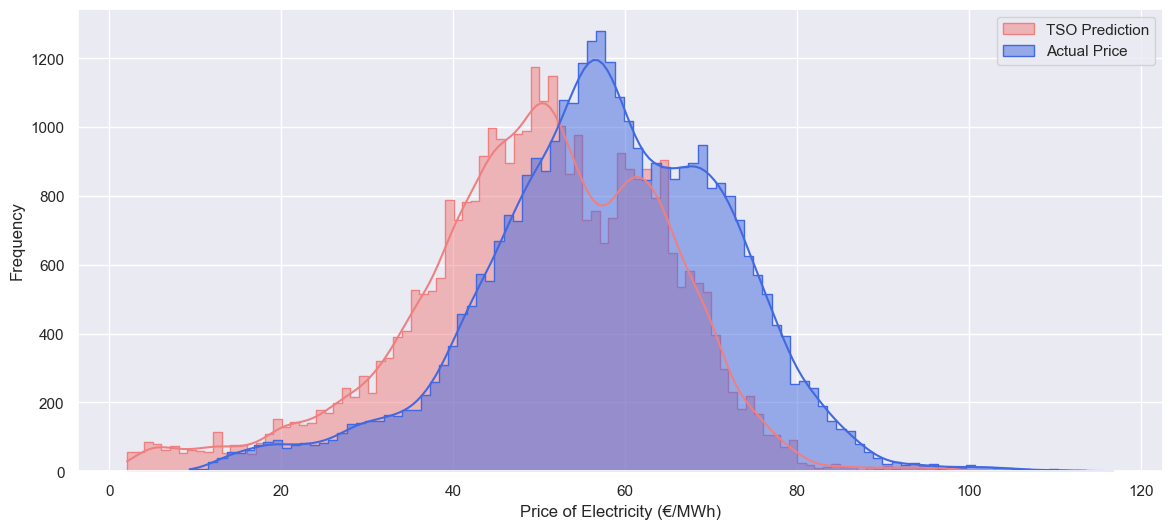

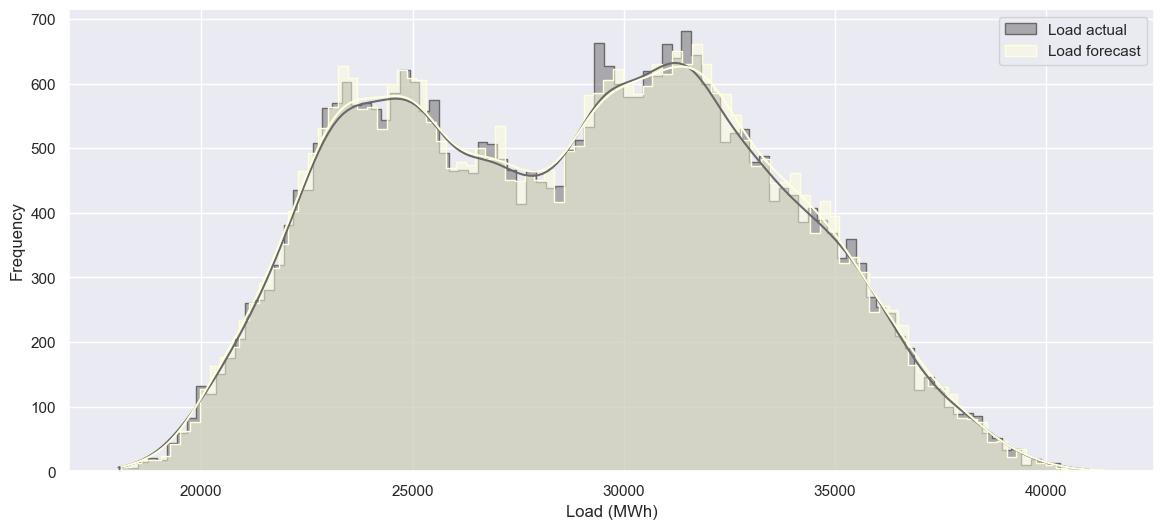

In [55]:
# distribution comparision, how price day head values compare to price actual  same for load actual and load forcast
plt.figure(figsize=(14,6))

gr = sns.histplot(df_weather_energy['price day ahead'], bins=100, label='TSO Prediction', element="step", color='lightcoral', kde = True)
gr = sns.histplot(df_weather_energy['price actual'], bins=100, label='Actual Price', element="step", color='royalblue', kde = True)


gr.set(xlabel="Price of Electricity (€/MWh)", ylabel="Frequency")
plt.legend()
plt.show()

plt.figure(figsize=(14,6))
gr = sns.histplot(df_weather_energy['total load actual'], bins=100, label='Load actual', element="step", color='dimgrey', kde = True)
gr = sns.histplot(df_weather_energy['total load forecast'], bins=100, label='Load forecast', element="step", color='lightyellow', kde = True)

gr.set(xlabel="Load (MWh)", ylabel="Frequency")
plt.legend()
plt.show()

In [56]:
# normalize data 
y_scaler_actual = MinMaxScaler()
y_scaler_dayahead = MinMaxScaler()
# split dataset to train and test set
train_cutoff = int(0.8*df_weather_energy.shape[0])
val_cutoff = int(0.9*df_weather_energy.shape[0])

y_price_actual   = df_weather_energy[['price actual']]
y_price_dayahead = df_weather_energy[['price day ahead']]

y_scaler_actual.fit(y_price_actual[:train_cutoff])
actual_norm = y_scaler_actual.transform(y_price_actual)

y_scaler_dayahead.fit(df_weather_energy[['price day ahead']][:train_cutoff])
dayahead_norm = y_scaler_dayahead.transform(y_price_dayahead)

print(f' mean absolute error for normalized acutal price and TSO predcition is : {round(mean_absolute_error(actual_norm, dayahead_norm),3)}')

 mean absolute error for normalized acutal price and TSO predcition is : 0.071


I tried to estimate the mean absolute error for normalized acutal price and TSO predcition (price day ahead) on the test set. I tried to normalized the data because I used normalized data for training part, so the comparision would be easy. Later you will find I considered that last 10 % of the data as test set! so int(0.9*df_weather_energy.shape[0]) represents the begining index of the test size. So the MAE for TSO prediction for the test size is 0.07

In [57]:
#There is a very high correlation between Total load forecasting and total load actual,so I removed total load forcast

df_weather_energy.drop(['total load forecast'], axis = 1, inplace = True)

# Note:
decompose the price actual into trend, seasonality and residual(noise). for better visualization, I ploted 100 first observed seasonality and call it as zoomed seasonality.

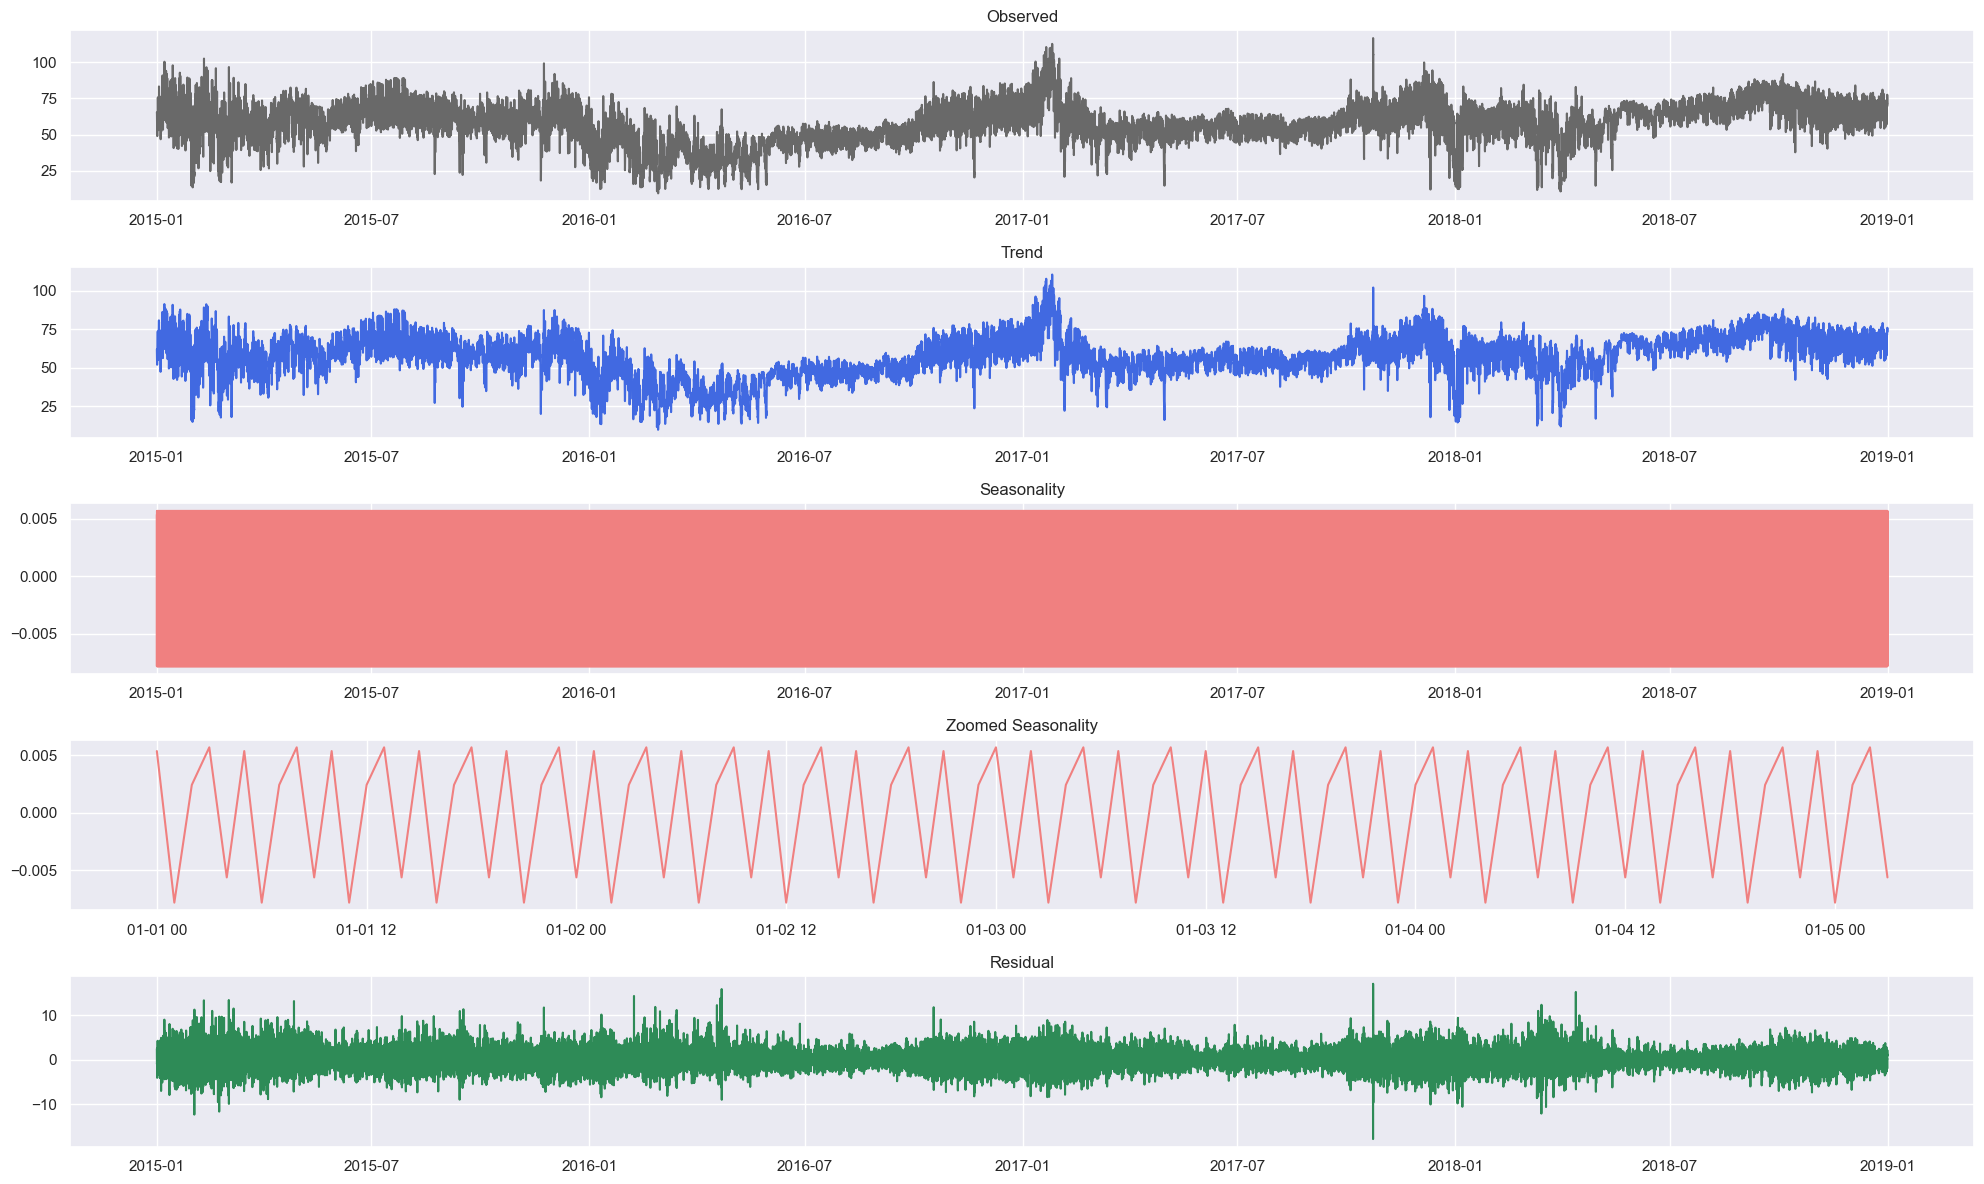

In [58]:
fig, axes = plt.subplots(5, 1, figsize=(20, 12))
decom_data = df_weather_energy[['price actual']].copy()

decompose_result = seasonal_decompose(decom_data, period =5, model='additive')

observed    = decompose_result.observed
trend    = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

axes[0].plot(observed, color='dimgrey')
axes[0].set_title('Observed')
axes[1].plot(trend, color='royalblue')
axes[1].set_title('Trend')
axes[2].plot(seasonal, color='lightcoral')
axes[2].set_title('Seasonality')
axes[3].plot(seasonal[:100], color='lightcoral')
axes[3].set_title('Zoomed Seasonality')
axes[4].plot(residual, color='seagreen')
axes[4].set_title('Residual')

fig.tight_layout()
plt.show()

The Dickey-Fuller test , also known as the Augmented Dickey-Fuller (ADF) test, is a statistical test used to determine whether a time series is stationary or not. Stationarity is an important concept in time series analysis because it affects the ability to model and predict future values. The test uses a null hypothesis that the time series has a unit root, meaning that it is non-stationary. The alternative hypothesis is that the time series is stationary. The test statistic is compared to critical values from tables or computed via a statistical software package. If the test statistic is less than the critical value, the null hypothesis is rejected, and it is concluded that the time series is stationary.

In [59]:
result = adfuller(df_weather_energy[['price actual']])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -9.147016232851223
p-value: 2.750493484933694e-15
Critical Values: {'1%': -3.4305367814665044, '5%': -2.8616225527935106, '10%': -2.566813940257257}


## Note
ADF statistics is even lower than the p value with 1% significance level. So the time series is considered as stationary!


Autocorrelation is a measure of the linear dependence between a time series and its lagged values. It measures how strongly the values of a time series at one time are correlated with the values at other times. Autocorrelation can be positive (indicating that high values tend to be followed by high values and low values tend to be followed by low values) or negative (indicating that high values tend to be followed by low values and vice versa).

Partial autocorrelation, on the other hand, measures the linear dependence between a time series and its lagged values, after removing the effect of any intermediate lags . It provides a measure of the direct correlation between two time points, taking into account any indirect correlation through intermediate time points. Partial autocorrelation can help identify the order of an autoregressive (AR) model, which is a model that uses lagged values of the time series as predictors.

In [60]:
df_weather_energy['price actual'].describe()

count    35064.000000
mean        57.884023
std         14.204083
min          9.330000
25%         49.347500
50%         58.020000
75%         68.010000
max        116.800000
Name: price actual, dtype: float64

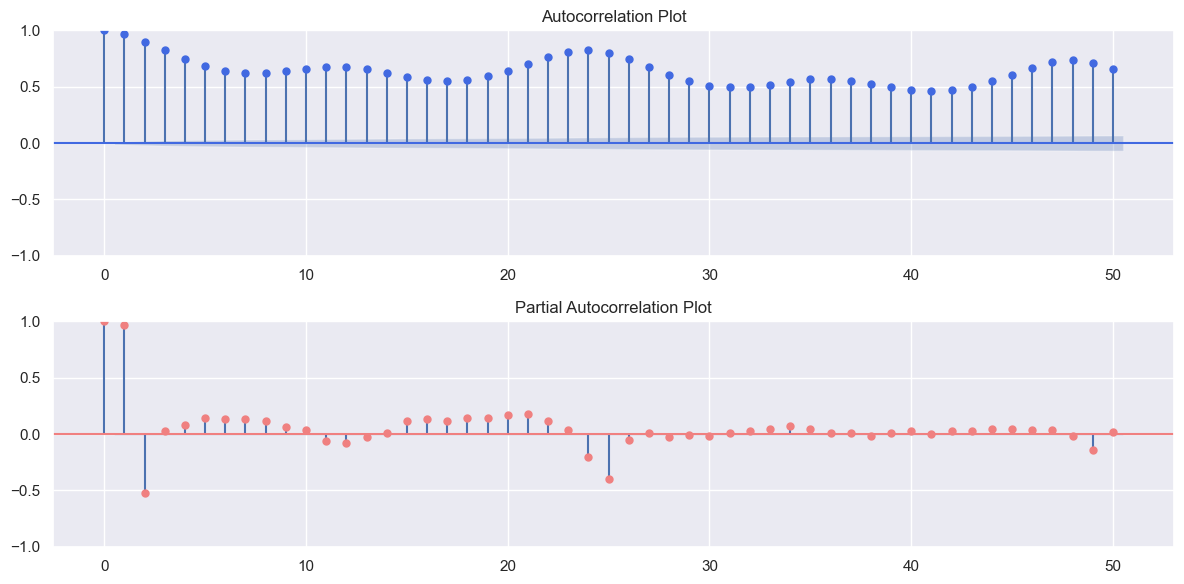

In [61]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(df_weather_energy['price actual'], lags=50, ax=ax[0], color='royalblue')
ax[0].set_title('Autocorrelation Plot')
plot_pacf(df_weather_energy['price actual'], lags=50, ax=ax[1], color='lightcoral')
ax[1].set_title('Partial Autocorrelation Plot')
plt.tight_layout()
plt.show()

# Observation 
Tall bars for many lags near 1 (top chart): the series has a long memory—values today look very much like recent past values. It changes slowly.

Wave that rises again around ~24 and ~48: there’s a daily rhythm. The value at, say, 2 pm today looks a lot like 2 pm yesterday (≈24 steps) and two days ago (≈48).
To predict the next value, the last 1–2 hours and the value 24 hours ago are especially helpful.

# Dimensionality reduction and train-test split
In this section I applied PCA for dimensionality reduction and add windowing to the dataset to make it prepared as input for tensorflow. I also split the train, validation and test sets and plot it with seperate colors in the figure. For faster convergnce and better performance of ML/DL models I normalzed the dataset.

In [62]:
X = df_weather_energy.drop(['price actual'], axis = 1)
y= df_weather_energy[['price actual']]

In [63]:
def apply_PCA(X_input, cum_variance, if_apply):
    
    if if_apply:
    
        pca = PCA(n_components = cum_variance)
        # make pipeline to first standardize then apply PCA on data
        scaler_pca = make_pipeline(MinMaxScaler(), pca)
        X_pca = scaler_pca.fit(X_input).transform(X_input)

        return X_pca
    
    else:
        
        return np.array(X_input)

In [64]:
params_pca = {'cum_variance' : 0.8, 'if_apply' : True }
X_pca = apply_PCA(X, **params_pca)
X_pca.shape

(35064, 15)

In [65]:
def windowing(X_input,y_input, history_size):
    
    data = []
    labels = []
    for i in range(history_size, len(y_input)):
        data.append(X_input[i - history_size : i, :])
        labels.append(y_input[i])
        
    return np.array(data), np.array(labels).reshape(-1,1)

In [66]:
#Normalizing target varialbe, since we already normalized features during the process of applying PCA!
train_cutoff = int(0.8*X_pca.shape[0])
val_cutoff   = int(0.9*X_pca.shape[0])

scaler_y = MinMaxScaler()
scaler_y.fit(y[:train_cutoff])
y_norm = scaler_y.transform(y)

In [67]:
hist_size= 24
data_norm = np.concatenate((X_pca,y_norm), axis = 1)

X_train, y_train = windowing(data_norm[:train_cutoff,:],data_norm[:train_cutoff,-1], hist_size)
X_val, y_val     = windowing(data_norm[train_cutoff :val_cutoff,:],data_norm[train_cutoff:val_cutoff,-1], hist_size)
X_test, y_test   = windowing(data_norm[val_cutoff :,:],data_norm[val_cutoff:,-1], hist_size)

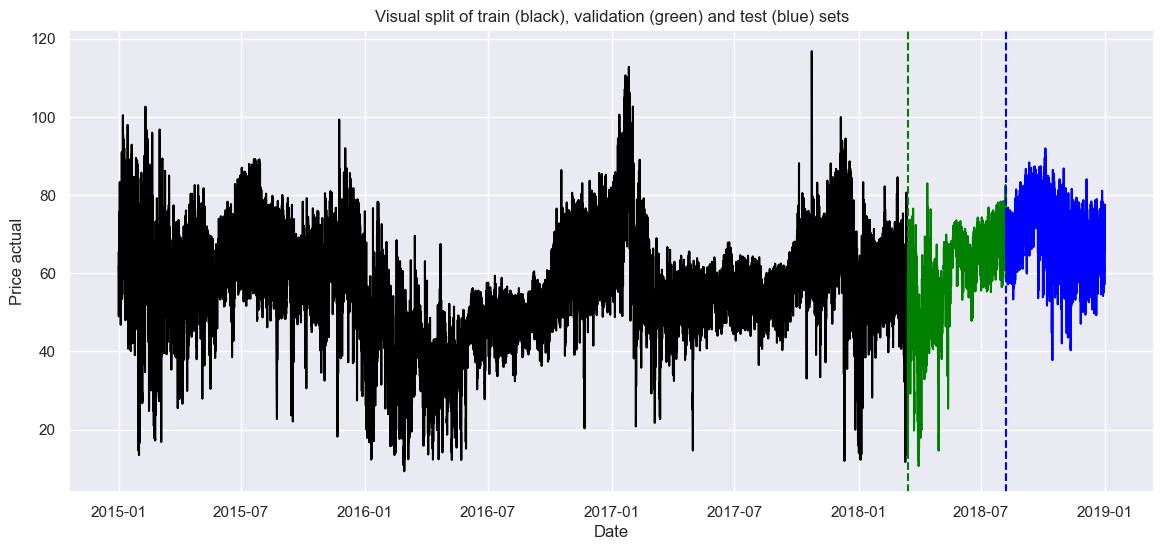

In [68]:
fig, axes = plt.subplots(figsize = (14,6))
axes.plot(df_weather_energy['price actual'].iloc[:train_cutoff], color = 'black')
axes.plot(df_weather_energy['price actual'].iloc[train_cutoff + 1 : val_cutoff], color = 'green')
axes.plot(df_weather_energy['price actual'].iloc[val_cutoff + 1 :], color = 'blue')
axes.axvline(x=df_weather_energy.index[train_cutoff], color='green', linestyle='--')
axes.axvline(x=df_weather_energy.index[val_cutoff], color='blue', linestyle='--')
axes.set_title('Visual split of train (black), validation (green) and test (blue) sets')
axes.set_xlabel('Date')
axes.set_ylabel('Price actual')
plt.show()

# Forecasting
1) XGBoost

XGBoost (sklearn API) expects a 2D array: (n_samples, n_features).

Time series windows are 3D: (n_samples, lookback, n_raw_features) 

Why I use MAE?
simple to compare across models they tried (XGB, GRU, LSTM, hybrids).


In [69]:
def reshaping(X):
    
    reshaped_x = X.reshape(-1 , X.shape[1] * X.shape[2])
    return reshaped_x

X_train_xgb = reshaping(X_train)
X_val_xgb   = reshaping(X_val)
X_test_xgb  = reshaping(X_test)

In [70]:

xgb_model = xgb.XGBRegressor()


# the code commented below does hyperparamter tunning for XGBoost!
#-----------------------------------------
# Grid of parameters to choose from

# xgb_params = {
#     "n_estimators": [10, 50, 100],
#     "subsample":[0.6, 0.8, 1],
#     "learning_rate":[0.01, 0.1, 0.5, 1],
#     "gamma":[0.01, 0.1, 1, 5],
#     "alpha":[0, 0.1, 0.5]
# }

# grid_xgb = GridSearchCV(xgb_hp_tunning, xgb_params, cv = 3)

# grid_xgb.fit(X_train_xgb, y_train)
# xgb_best_model = grid_xgb.best_estimator_

# y_pred = xgb_best_model.predict(X_test_xgb)

# mae = mean_absolute_error(y_pred, y_test_xgb)
# print(f'Mean Absolute Error: {round(mae,3)}')
#---------------------------------------------


# Fit the model
xgb_model.fit(X_train_xgb, y_train,
               eval_set=[(X_train_xgb, y_train), (X_val_xgb, y_val)],     
               eval_metric='mae',
               early_stopping_rounds=8,
               verbose=False) 

/opt/anaconda3/envs/ai-ml/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

/opt/anaconda3/envs/ai-ml/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [71]:
def plot_results(y_pred_actual, y_test_inv, model, model_name):
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))
    
    ax[0].plot(y_pred_actual[:1000])
    ax[0].plot(y_test_inv[:1000])
    ax[0].legend(['prediction', 'actual'], loc='upper left')
    ax[0].set_title(f'Prediction vs actual price for 1000 observation in test set ({model_name})')
    ax[0].set_xlabel('Observation')
    ax[0].set_ylabel('Price')
    
    if model != 'hybrid':
    
        if model_name == 'XGBoost':

            train_mae = model.evals_result()['validation_0']['mae']
            val_mae = model.evals_result()['validation_1']['mae']
            ax[1].plot(train_mae, label='Training MAE')
            ax[1].plot(val_mae, label='Validation MAE')

        else:

            ax[1].plot(history.history['loss'], label='Training Loss')
            ax[1].plot(history.history['val_loss'], label='Validation Loss')

        ax[1].legend()
        ax[1].set_title(f'Training and validation MAE ({model_name})')
        ax[1].set_xlabel('Iteration/Epochs')
        ax[1].set_ylabel('MAE')    
        
    fig.tight_layout()
    plt.show()
    



---------------------------------------------------
XGBoost MAE for test set : 0.016
---------------------------------------------------



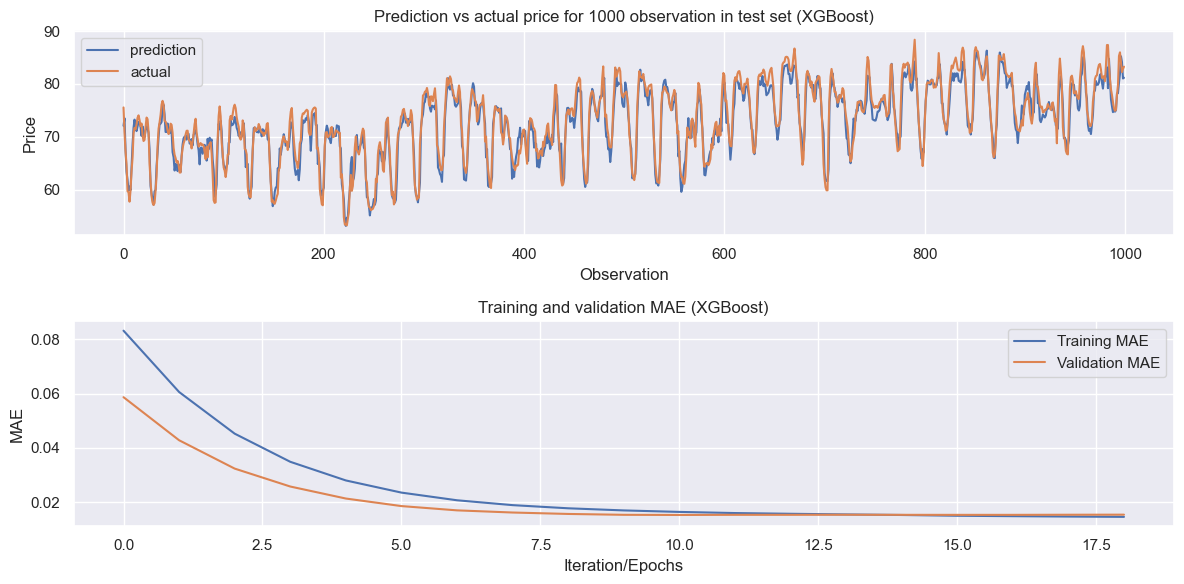

In [72]:
y_pred = xgb_model.predict(X_test_xgb) 
y_pred_actual = scaler_y.inverse_transform(y_pred.reshape(-1,1))
y_test_inv = scaler_y.inverse_transform(y_test)


print('')
print('')
print('---------------------------------------------------')
print(f'XGBoost MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
print('---------------------------------------------------')
print('')
plot_results(y_pred_actual, y_test_inv, xgb_model,'XGBoost')

# 2. GRU

In [77]:
tf.keras.backend.clear_session()

In [74]:

def base_model_gru():
    
    model = Sequential()
    model.add(GRU(units=32, return_sequences=True, activation="relu", input_shape=X_train.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    
    return model

gru_model = base_model_gru()

/opt/anaconda3/envs/ai-ml/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [79]:
# inputs for DL models
import tensorflow_addons as tfa
epoch = 100
batch_size = 64
steps_per_epoch = len(X_train) // batch_size
cyclic_lr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-04,
                                                maximal_learning_rate=1e-02,
                                                scale_fn=lambda x: 1/(2**(x-1)),
                                                step_size=6 * steps_per_epoch)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
optimizer = Adam(learning_rate=cyclic_lr, amsgrad=True)

/opt/anaconda3/envs/ai-ml/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning:



TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 


/opt/anaconda3/envs/ai-ml/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning:

Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.16.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to ma

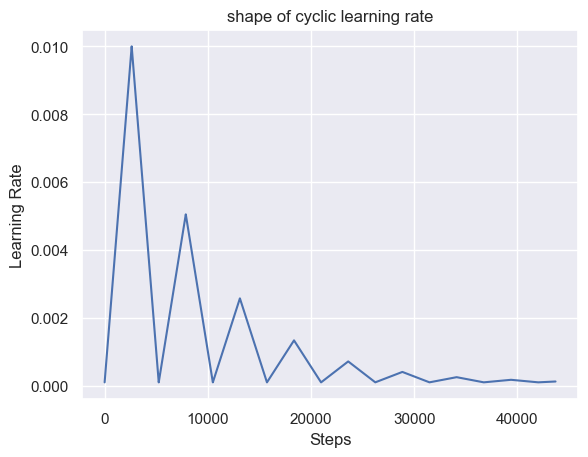

In [80]:
step = np.arange(0, epoch * steps_per_epoch)
lr = cyclic_lr(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("shape of cyclic learning rate")
plt.show()

In [81]:
gru_model.compile(optimizer = optimizer , loss = 'mean_absolute_error')
history = gru_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epoch, 
                   batch_size = batch_size, callbacks=[callback])

Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0732 - val_loss: 0.0398
Epoch 2/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0403 - val_loss: 0.0341
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0328 - val_loss: 0.0228
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0274 - val_loss: 0.0202
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0251 - val_loss: 0.0201
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0253 - val_loss: 0.0277
Epoch 7/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0231 - val_loss: 0.0236
Epoch 8/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0218 - val_loss: 0.0237
Epoch 9/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0198 - val_loss: 0.0161
Epoch 10/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0188 - val_loss: 0.0143
Epoch 11/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0178 - val_loss: 0.0142
Epoch 12/100
438/438 ━━━━━━━━━━━━━━━━━━━

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


---------------------------------------------------
GRU MAE for test set : 0.016
---------------------------------------------------



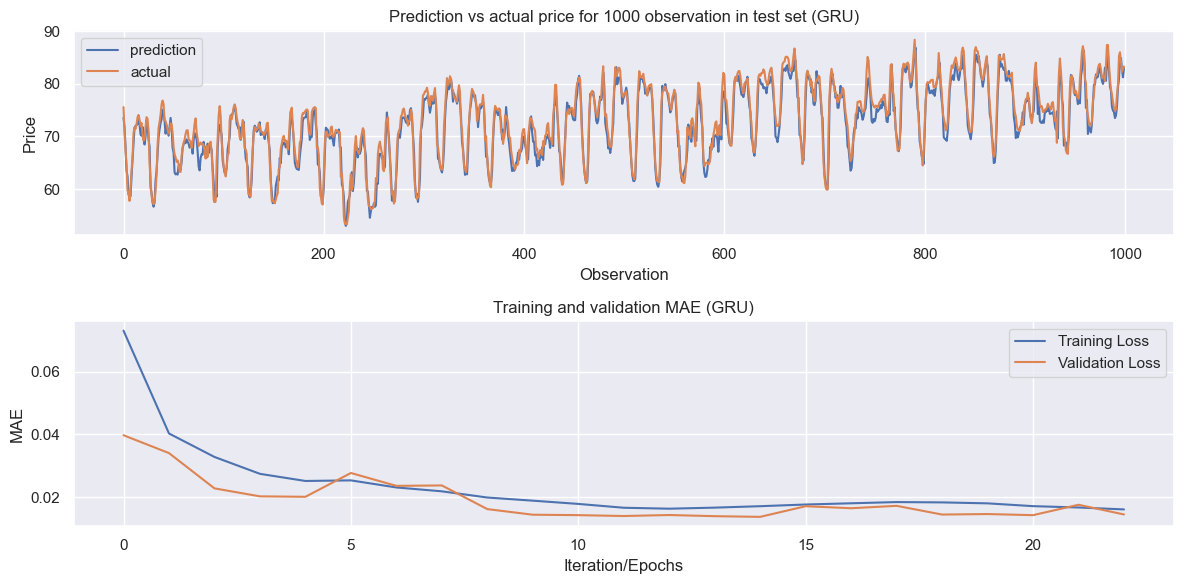

In [82]:
y_pred = gru_model.predict(X_test)
print('')
print('')
print('---------------------------------------------------')
print(f'GRU MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'GRU')

# 3. LSTM

In [90]:
tf.keras.backend.clear_session()

In [91]:
# 1) Start clean
tf.keras.backend.clear_session()

# 2) Rebuild the model
def base_model_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, activation="relu", input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    return model

lookback = X_train.shape[1]
n_feats  = X_train.shape[2]
lstm_model = base_model_lstm((lookback, n_feats))

# 3) Make a **fresh** LR schedule and **fresh** optimizer
batch_size = 64
epoch = 100
steps_per_epoch = len(X_train) // batch_size

cyclic_lr = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate=1e-4,
    maximal_learning_rate=1e-2,
    scale_fn=lambda x: 1/(2**(x-1)),
    step_size=6 * steps_per_epoch,    # iterations
)
optimizer = Adam(learning_rate=cyclic_lr, amsgrad=True)  # NEW instance

# 4) Compile (don’t force eager; not needed)
lstm_model.compile(optimizer=optimizer, loss='mae')

# 5) Train
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epoch,
    batch_size=batch_size,
    callbacks=[es],
    verbose=1
)

Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 57s 131ms/step - loss: 0.0745 - val_loss: 0.0491
Epoch 2/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 56s 128ms/step - loss: 0.0431 - val_loss: 0.0372
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 59s 134ms/step - loss: 0.0358 - val_loss: 0.0418
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 56s 128ms/step - loss: 0.0290 - val_loss: 0.0226
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 56s 127ms/step - loss: 0.0247 - val_loss: 0.0224
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 56s 128ms/step - loss: 0.0233 - val_loss: 0.0236
Epoch 7/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 60s 137ms/step - loss: 0.0223 - val_loss: 0.0173
Epoch 8/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 57s 130ms/step - loss: 0.0206 - val_loss: 0.0161
Epoch 9/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 55s 125ms/step - loss: 0.0193 - val_loss: 0.0184
Epoch 10/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 53s 121ms/step - loss: 0.0182 - val_loss: 0.0147
Epoch 11/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 55s 127ms/step - loss: 0.0174 - val_loss: 0.0148
Epoch 12

109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step


---------------------------------------------------
LSTM MAE for test set : 0.015
---------------------------------------------------



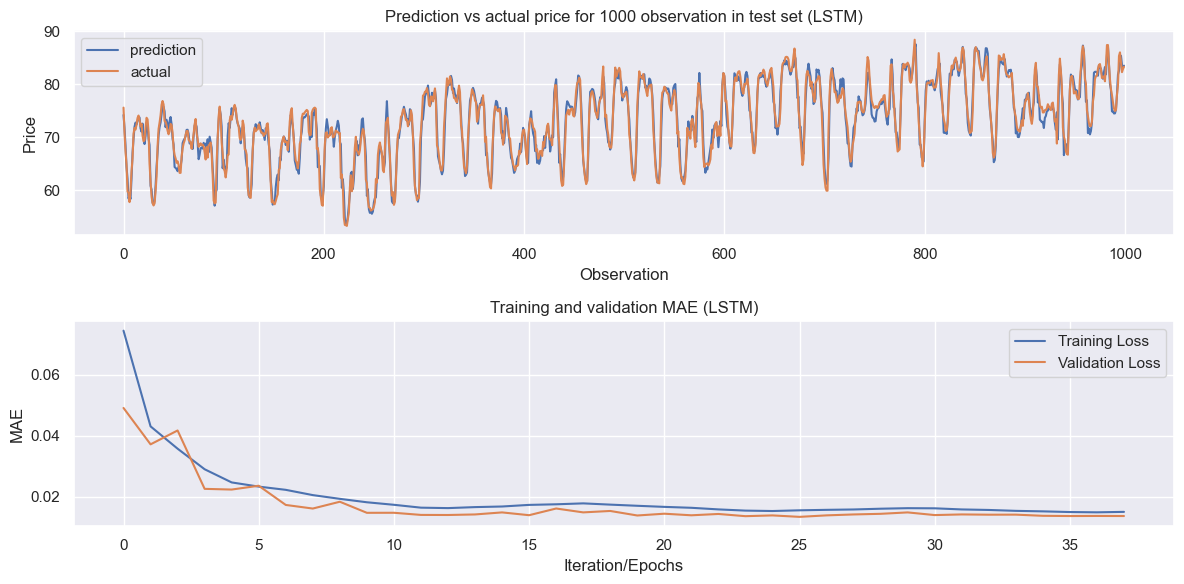

In [92]:
y_pred = lstm_model.predict(X_test)
print('')
print('')
print('---------------------------------------------------')
print(f'LSTM MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'LSTM')

# 4.CNN

In [101]:
tf.keras.backend.clear_session()

# (2) Rebuild the CNN
cnn_model = base_model_cnn()

# (3) Make a FRESH LR schedule and a FRESH optimizer
steps_per_epoch = len(X_train) // batch_size
cyclic_lr_cnn = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate=1e-4,
    maximal_learning_rate=1e-2,
    scale_fn=lambda x: 1/(2**(x-1)),
    step_size=6 * steps_per_epoch,   # in iterations
)
optimizer_cnn = Adam(learning_rate=cyclic_lr_cnn, amsgrad=True)

# (4) Compile and train
cnn_model.compile(optimizer=optimizer_cnn, loss='mae')

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=12, restore_best_weights=True
)

history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epoch,
    batch_size=batch_size,
    callbacks=[es],
    verbose=1
)

/opt/anaconda3/envs/ai-ml/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/opt/anaconda3/envs/ai-ml/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - loss: 0.0939 - val_loss: 0.0409
Epoch 2/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - loss: 0.0431 - val_loss: 0.0389
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - loss: 0.0354 - val_loss: 0.0316
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - loss: 0.0321 - val_loss: 0.0317
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 0.0303 - val_loss: 0.0536
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - loss: 0.0305 - val_loss: 0.0261
Epoch 7/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - loss: 0.0285 - val_loss: 0.0250
Epoch 8/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 0.0254 - val_loss: 0.0205
Epoch 9/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - loss: 0.0230 - val_loss: 0.0185
Epoch 10/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - loss: 0.0213 - val_loss: 0.0175
Epoch 11/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - loss: 0.0193 - val_loss: 0.0161
Epoch 12/100
438/43

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


---------------------------------------------------
CNN MAE for test set : 0.014
---------------------------------------------------



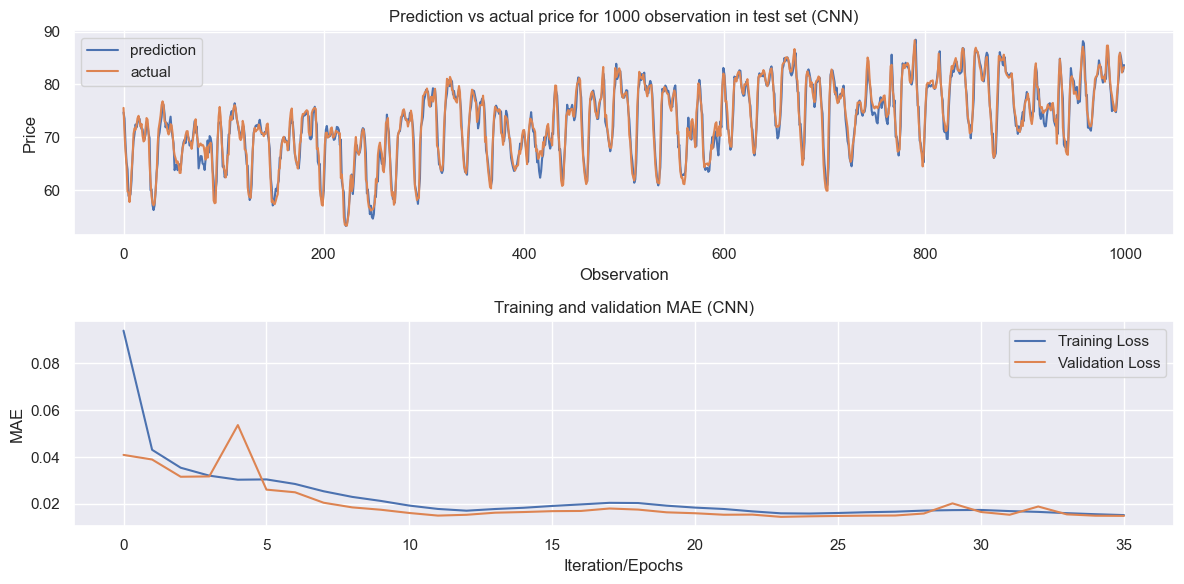

In [102]:
y_pred = cnn_model.predict(X_test)
print('')
print('')
print('---------------------------------------------------')
print(f'CNN MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'CNN')

# 5. CNN-LSTM

In [103]:
tf.keras.backend.clear_session()

In [105]:
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Flatten, GlobalAveragePooling1D

# ------- Shapes -------
lookback = X_train.shape[1]
n_feats  = X_train.shape[2]

# ------- (1) Start clean -------
tf.keras.backend.clear_session()

# ------- (2) Build the model -------
def base_model_cnn_lstm(input_shape):
    model = Sequential()
    # Tip: use padding='same' so timesteps don’t shrink before LSTM
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                     padding='same', input_shape=input_shape))
    # Tip: LSTM default (tanh) is usually more stable than relu
    model.add(LSTM(units=8, return_sequences=True))  # default activations
    # Flatten works, but GAP1D keeps params smaller; pick ONE of these:
    # model.add(Flatten())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    return model

cnn_lstm_model = base_model_cnn_lstm((lookback, n_feats))

# ------- (3) Fresh LR schedule + optimizer -------
batch_size = 64
epochs = 100
steps_per_epoch = len(X_train) // batch_size

cyclic_lr = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate=1e-4,
    maximal_learning_rate=1e-2,
    scale_fn=lambda x: 1/(2**(x-1)),  # each cycle peak halves
    step_size=6 * steps_per_epoch     # iterations; ~12 epochs per full cycle
)
optimizer = Adam(learning_rate=cyclic_lr, amsgrad=True)  # NEW instance

# ------- (4) Compile -------
cnn_lstm_model.compile(optimizer=optimizer, loss='mae')

# ------- (5) Callbacks -------
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=12, restore_best_weights=True
)
ckpt = tf.keras.callbacks.ModelCheckpoint(
    'best_cnn_lstm.keras', monitor='val_loss', save_best_only=True
)

# ------- (6) Train -------
history = cnn_lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[es, ckpt],
    verbose=1
)

/opt/anaconda3/envs/ai-ml/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 59s 135ms/step - loss: 0.0979 - val_loss: 0.0821
Epoch 2/100


/opt/anaconda3/envs/ai-ml/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:405: UserWarning:

The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     scale_fn=lambda x: 1/(2**(x-1)),  # each cycle peak halves




438/438 ━━━━━━━━━━━━━━━━━━━━ 56s 127ms/step - loss: 0.0547 - val_loss: 0.0680
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 61s 140ms/step - loss: 0.0477 - val_loss: 0.0472
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 74s 169ms/step - loss: 0.0434 - val_loss: 0.0448
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 62s 142ms/step - loss: 0.0401 - val_loss: 0.0494
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 59s 136ms/step - loss: 0.0379 - val_loss: 0.0418
Epoch 7/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 54s 124ms/step - loss: 0.0347 - val_loss: 0.0392
Epoch 8/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 55s 125ms/step - loss: 0.0323 - val_loss: 0.0354
Epoch 9/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 54s 124ms/step - loss: 0.0292 - val_loss: 0.0373
Epoch 10/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 54s 123ms/step - loss: 0.0277 - val_loss: 0.0415
Epoch 11/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 55s 125ms/step - loss: 0.0259 - val_loss: 0.0399
Epoch 12/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 56s 128ms/step - loss: 0.0241 - val_loss: 0.0400
Epoch 13/100
438/43

109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step


---------------------------------------------------
CNN-LSTM MAE for test set : 0.035
---------------------------------------------------



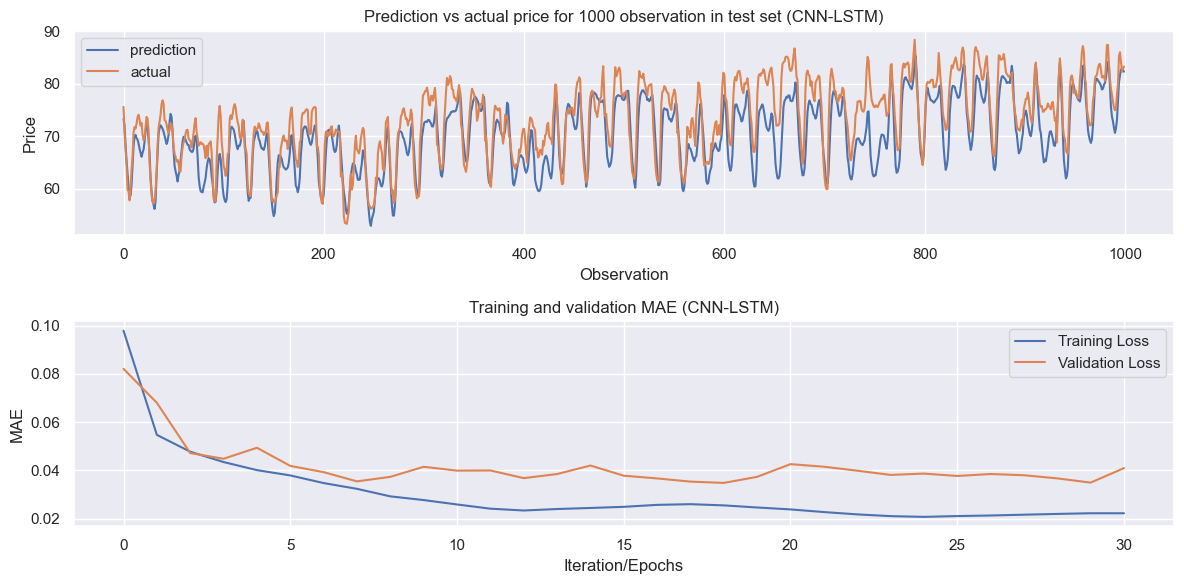

In [107]:
y_pred = cnn_lstm_model.predict(X_test)
print('')
print('')
print('---------------------------------------------------')
print(f'CNN-LSTM MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'CNN-LSTM')

# 6. LSTM-Attention

In [108]:
tf.keras.backend.clear_session()

In [112]:
from tensorflow.keras.layers import Masking, LSTM, Dense, Flatten, Dot

tf.keras.backend.clear_session()


def LSTM_attention():
    inputs = Input(shape=(hist_size, X_train.shape[2]))
  
    masked = Masking(mask_value=0.)(inputs)
    lstm = LSTM(132, return_sequences=True)(masked)


    attention = Dot(axes=[2, 2])([lstm, lstm])
    attention = Dense(hist_size, activation='softmax')(attention)  

    # apply attention weights to lstm sequence
    context = Dot(axes=[2, 1])([attention, lstm])

    flattened = Flatten()(context) 
    output = Dense(1)(flattened)
    return Model(inputs=inputs, outputs=output)

LSTM_attention_model = LSTM_attention()


batch_size = 64  
steps_per_epoch = len(X_train) // batch_size
cyclic_lr_att = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate=1e-4,
    maximal_learning_rate=1e-2,
    scale_fn=lambda x: 1/(2**(x-1)),
    step_size=6 * steps_per_epoch,   
)
optimizer_att = Adam(learning_rate=cyclic_lr_att, amsgrad=True)


LSTM_attention_model.compile(optimizer=optimizer_att, loss='mae')

LSTM_attention_model.summary()

history = LSTM_attention_model.fit(
    X_train, y_train,
    epochs=epoch, batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[callback],
    verbose=1
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 24, 16)    │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 24, 16)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 24)        │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 24, 132)   │     78,672 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 24, 24)    │          0 │ lstm[0][0],       │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 24, 24)    │        600 │ dot[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 24, 132)   │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3168)      │          0 │ dot_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      3,169 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 82,441 (322.04 KB)

 Trainable params: 82,441 (322.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 108s 246ms/step - loss: 0.0655 - val_loss: 0.0568
Epoch 2/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 107s 245ms/step - loss: 0.0432 - val_loss: 0.0316
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 107s 244ms/step - loss: 0.0327 - val_loss: 0.0252
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 105s 240ms/step - loss: 0.0272 - val_loss: 0.0196
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 110s 250ms/step - loss: 0.0241 - val_loss: 0.0183
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 106s 241ms/step - loss: 0.0235 - val_loss: 0.0183
Epoch 7/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 106s 241ms/step - loss: 0.0216 - val_loss: 0.0165
Epoch 8/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 107s 244ms/step - loss: 0.0201 - val_loss: 0.0178


109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step


---------------------------------------------------
LSTM-Attention MAE for test set : 0.02
---------------------------------------------------



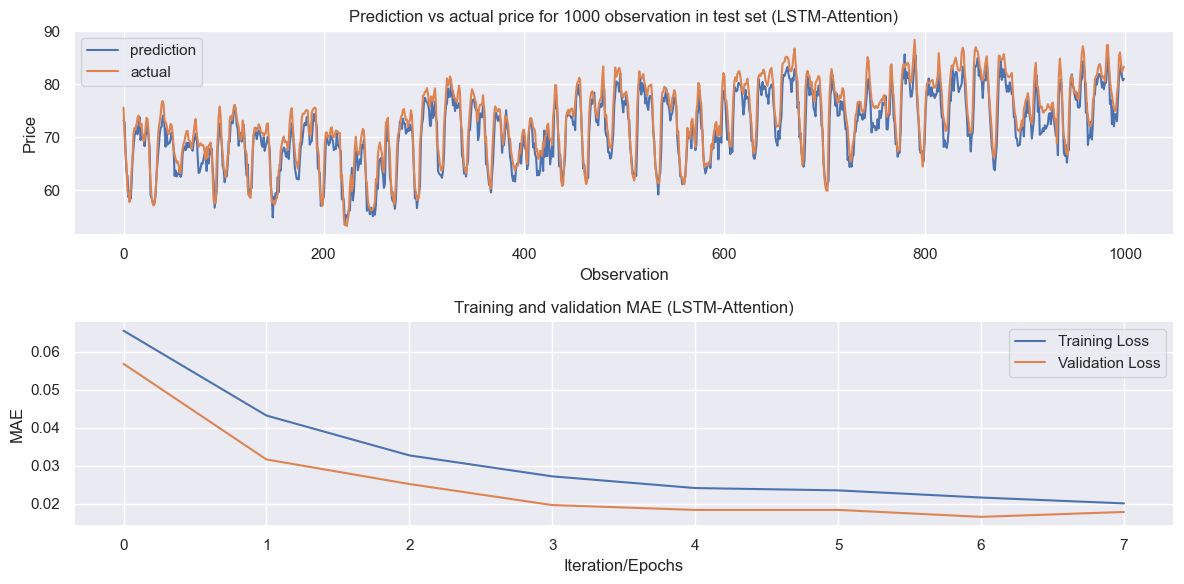

In [113]:
y_pred = LSTM_attention_model.predict(X_test)
print('')
print('')

print('---------------------------------------------------')
print(f'LSTM-Attention MAE for test set : {round(mean_absolute_error(y_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'LSTM-Attention')

# 7. Hybrid GRU-XGBoost

In [114]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa


tf.keras.backend.clear_session()

def base_model_gru():
    model = Sequential()
    model.add(GRU(units=32, return_sequences=True, activation="relu", input_shape=X_train.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    return model

gru_model = base_model_gru()


steps_per_epoch = len(X_train) // batch_size
cyclic_lr_gru = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate=1e-4,
    maximal_learning_rate=1e-2,
    scale_fn=lambda x: 1/(2**(x-1)),
    step_size=6 * steps_per_epoch,   # in iterations
)
optimizer_gru = Adam(learning_rate=cyclic_lr_gru, amsgrad=True)

gru_model.compile(optimizer=optimizer_gru, loss='mean_absolute_error')

print('')
print('GRU is fitting a model on train-validation sets...')
print('')

gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epoch,
    batch_size=batch_size,
    callbacks=[callback]
)

print('')
print('----------------------------------')
print('GRU is predicting...')
print('')

residuals_train = y_train - gru_model.predict(X_train)
residuals_val   = y_val   - gru_model.predict(X_val)

print('')
print('----------------------------------')
print('XGBoost is fitting a model on residuals...')
print('')

xgb_hybrid = xgb.XGBRegressor()
xgb_hybrid.fit(
    X_train_xgb, residuals_train,
    eval_set=[(X_train_xgb, residuals_train), (X_val_xgb, residuals_val)],
    eval_metric='mae',
    early_stopping_rounds=8,
    verbose=False
)

y_train_pred = gru_model.predict(X_train) + xgb_hybrid.predict(X_train_xgb).reshape(-1,1)
y_val_pred   = gru_model.predict(X_val)   + xgb_hybrid.predict(X_val_xgb).reshape(-1,1)


/opt/anaconda3/envs/ai-ml/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/opt/anaconda3/envs/ai-ml/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.




GRU is fitting a model on train-validation sets...

Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 90s 206ms/step - loss: 0.0723 - val_loss: 0.0487
Epoch 2/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 85s 193ms/step - loss: 0.0422 - val_loss: 0.0335
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 80s 184ms/step - loss: 0.0329 - val_loss: 0.0301
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 84s 192ms/step - loss: 0.0276 - val_loss: 0.0269
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 84s 193ms/step - loss: 0.0256 - val_loss: 0.0166
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 82s 187ms/step - loss: 0.0246 - val_loss: 0.0221
Epoch 7/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 80s 184ms/step - loss: 0.0235 - val_loss: 0.0186
Epoch 8/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 80s 182ms/step - loss: 0.0217 - val_loss: 0.0176

----------------------------------
GRU is predicting...

876/876 ━━━━━━━━━━━━━━━━━━━━ 64s 73ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step

----------------------------------
XGBoost is fitting a model on residuals...



/opt/anaconda3/envs/ai-ml/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

/opt/anaconda3/envs/ai-ml/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



876/876 ━━━━━━━━━━━━━━━━━━━━ 64s 72ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step


109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step


---------------------------------------------------
GRU-XGBoost MAE for test set : 0.015
---------------------------------------------------



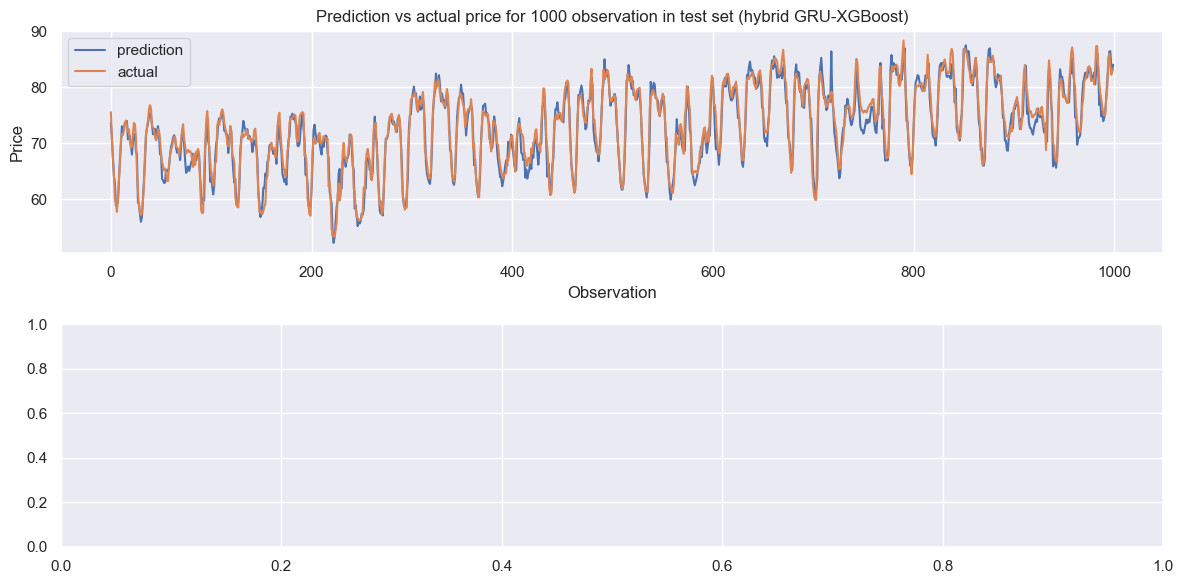

In [115]:
y_test_pred  = gru_model.predict(X_test) + xgb_hybrid.predict(X_test_xgb).reshape(-1,1)
print('')
print('')

print('---------------------------------------------------')
print(f'GRU-XGBoost MAE for test set : {round(mean_absolute_error(y_test_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_test_pred)
print('')
plot_results(y_pred_actual, y_test_inv, 'hybrid' ,'hybrid GRU-XGBoost')

# 8. Hybrid LSTM-Attention-XGBoost

In [118]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Masking, LSTM, Dense, Flatten, Dot
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
import tensorflow as tf

tf.keras.backend.clear_session()

def LSTM_attention():
    inputs = Input(shape=(hist_size, X_train.shape[2]))

    masked = Masking(mask_value=0.)(inputs)
    lstm = LSTM(132, return_sequences=True)(masked)


    attention = Dot(axes=[2, 2])([lstm, lstm])

    attention = Dense(hist_size, activation='softmax')(attention)


    context = Dot(axes=[2, 1])([attention, lstm])

    flattened = Flatten()(context)
    output = Dense(1)(flattened)
    model = Model(inputs=inputs, outputs=output)
    return model

LSTM_attention_model = LSTM_attention()


steps_per_epoch = len(X_train) // batch_size
cyclic_lr_att = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate=1e-4,
    maximal_learning_rate=1e-2,
    scale_fn=lambda x: 1/(2**(x-1)),
    step_size=6 * steps_per_epoch, 
)
optimizer_att = Adam(learning_rate=cyclic_lr_att, amsgrad=True)

LSTM_attention_model.compile(optimizer=optimizer_att, loss='mae')

print('\nLSTM-Attention is fitting a model on train-validation sets...\n')
history = LSTM_attention_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epoch,
    batch_size=batch_size,
    callbacks=[callback],
    verbose=1
)

print('\n----------------------------------\nLSTM-attention is predicting...\n')
residuals_train = y_train - LSTM_attention_model.predict(X_train)
residuals_val   = y_val   - LSTM_attention_model.predict(X_val)

print('\n----------------------------------\nXGBoost is fitting a model on residuals...\n')
xgb_hybrid = xgb.XGBRegressor()
xgb_hybrid.fit(
    X_train_xgb, residuals_train,
    eval_set=[(X_train_xgb, residuals_train), (X_val_xgb, residuals_val)],
    eval_metric='mae',
    early_stopping_rounds=8,
    verbose=False
)

y_train_pred = LSTM_attention_model.predict(X_train) + xgb_hybrid.predict(X_train_xgb).reshape(-1,1)
y_val_pred   = LSTM_attention_model.predict(X_val)   + xgb_hybrid.predict(X_val_xgb).reshape(-1,1)



LSTM-Attention is fitting a model on train-validation sets...



/opt/anaconda3/envs/ai-ml/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 115s 261ms/step - loss: 0.0704 - val_loss: 0.0407
Epoch 2/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 103s 236ms/step - loss: 0.0416 - val_loss: 0.0374
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 103s 236ms/step - loss: 0.0299 - val_loss: 0.0232
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 107s 245ms/step - loss: 0.0243 - val_loss: 0.0164
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 103s 235ms/step - loss: 0.0233 - val_loss: 0.0204
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 104s 238ms/step - loss: 0.0230 - val_loss: 0.0188
Epoch 7/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 104s 237ms/step - loss: 0.0215 - val_loss: 0.0177
Epoch 8/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 104s 237ms/step - loss: 0.0203 - val_loss: 0.0146

----------------------------------
LSTM-attention is predicting...

876/876 ━━━━━━━━━━━━━━━━━━━━ 63s 72ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step

----------------------------------
XGBoost is fitting a model on residuals...



/opt/anaconda3/envs/ai-ml/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

/opt/anaconda3/envs/ai-ml/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



876/876 ━━━━━━━━━━━━━━━━━━━━ 63s 71ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step


109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step


---------------------------------------------------
LSTM-Attention-XGBoost MAE for test set : 0.015
---------------------------------------------------



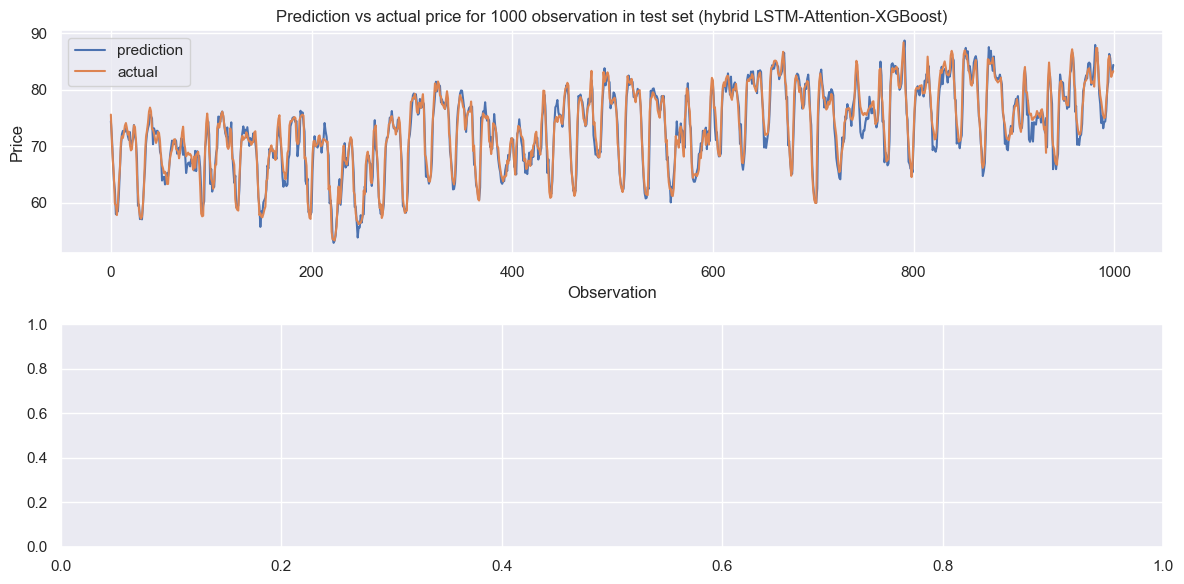

In [119]:
y_test_pred  = LSTM_attention_model.predict(X_test) + xgb_hybrid.predict(X_test_xgb).reshape(-1,1)
print('')
print('')

print('---------------------------------------------------')
print(f'LSTM-Attention-XGBoost MAE for test set : {round(mean_absolute_error(y_test_pred,y_test),3)}')
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_test_pred)
print('')
plot_results(y_pred_actual, y_test_inv, 'hybrid' ,'hybrid LSTM-Attention-XGBoost')

Results

The MAE (Mean Absolute Error) is used to report the results for the normalized test set:

TSO prediction : 0.070
XGboost : 0.016
GRU : 0.015
LSTM : 0.018
CNN : 0.025
CNN-LSTM : 0.019
LSTM-Attention : 0.015
Hybrid GRU-XGBoost : 0.014
Hybrid LSTM-Attention-XGBoost : 0.015
Note : According to the findings, the hybrid methods demonstrated better performance in terms of MAE compared to other methods. It is worth mentioning that all machine learning/deep learning methods outperformed TSO prediction.

 